# Flight Status Exploration and Prediction

In this notebook, we will step through the entire Data Science Framework described in both the Google Data Analytics Certificate and the Google Advanced Data Analytics course to analyse 13GB worth of flight status data spanning 5 years (2018-2022).

# About the Data
- The data was found on [Kaggle](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022/)

-  It contains data about flights from different airports from 2018 to 2022.
- It has 61 columns.

# PACE Stages
![PACE Stages](pace.png)
## Plan Stage
### Understanding the Business Scenario and Problem
- In this notebook we will attempt to analyse the data and do the following tasks:
    1. **predict whether flights will be cancelled or delayed**.
    2. **explore how different airlines compare**

- Being able to predict flight delays and cancellations will be useful to both airports and airlines.

- Airlines can take this information into account when scheduling crew and aircraft assignments to routes.

- It can also help airports identify time periods of peak demand, when they may need more manpower or have to scale back on slots they allow at the airport.

### Identifying Tools and Software Packages for the Project
- The large size of the data creates an opportunity for us to use Data Analysis tools typically used for Big Data.

- The data is stored in an S3 bucket, and we use a distributed EMR cluster to extract the data and perform analysis on it. 

- You can use Amazon EMR Notebooks along with Amazon EMR clusters running Apache Spark to create and open Jupyter Notebook and JupyterLab interfaces.

- This easy integration with Jupyter Lab and Jupyter Notebooks is the main reason why an AWS ecosystem was chosen


In [1]:
%%info

In [2]:
%%configure -f
{ "conf":{
          "spark.pyspark.python": "python3",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
         }
}

In [3]:
sc.list_packages()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1693987508066_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

aws-cfn-bootstrap (2.0)
beautifulsoup4 (4.9.3)
boto (2.49.0)
click (8.0.3)
docutils (0.14)
jmespath (0.10.0)
joblib (1.1.0)
lockfile (0.11.0)
lxml (4.6.3)
mysqlclient (1.4.2)
nltk (3.6.5)
nose (1.3.4)
numpy (1.16.5)
pip (9.0.1)
py-dateutil (2.2)
pystache (0.5.4)
python-daemon (2.2.3)
python37-sagemaker-pyspark (1.4.1)
pytz (2021.3)
PyYAML (5.4.1)
regex (2021.10.21)
setuptools (28.8.0)
simplejson (3.2.0)
six (1.13.0)
tqdm (4.62.3)
wheel (0.29.0)
windmill (1.6)

DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [4]:
sc.install_pypi_package("matplotlib==3.1.0", "https://pypi.org/simple")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [5]:
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [6]:
sc.install_pypi_package("scipy==1.1.0")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [7]:
sc.install_pypi_package("seaborn==0.9.0")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [8]:
sc.install_pypi_package("calmap==0.0.7")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [9]:
sc.install_pypi_package("plotly==4.1.0")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [43]:
# imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sns
import numpy as np
import calmap


from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Analyze Stage
## Load the Data

In [11]:
# define paths to s3 bucket
s3_2018_path = "s3://airplane-data-240823/Combined_Flights_2018.csv"
s3_2019_path = "s3://airplane-data-240823/Combined_Flights_2019.csv"
s3_2020_path = "s3://airplane-data-240823/Combined_Flights_2020.csv"
s3_2021_path = "s3://airplane-data-240823/Combined_Flights_2021.csv"
s3_2022_path = "s3://airplane-data-240823/Combined_Flights_2022.csv"


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_2018 = spark.read.csv(s3_2018_path, header=True, inferSchema=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## EDA

In [13]:
# check first row
df_2018.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|          Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrD

In [14]:
df_2018.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- FlightDate: string (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)


In [13]:
# read in other years of data
df_2019 = spark.read.csv(s3_2019_path, header=True, inferSchema=True)
df_2020 = spark.read.csv(s3_2020_path, header=True, inferSchema=True)
df_2021 = spark.read.csv(s3_2021_path, header=True, inferSchema=True)
df_2022 = spark.read.csv(s3_2022_path, header=True, inferSchema=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Check for nulls
null_counts_2018 = df_2018.agg(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_2018.columns]).collect()[0].asDict()

for column, null_count in null_counts_2018.items():
    print(f"{column}: {null_count} nulls")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FlightDate: 0 nulls
Airline: 0 nulls
Origin: 0 nulls
Dest: 0 nulls
Cancelled: 0 nulls
Diverted: 0 nulls
CRSDepTime: 0 nulls
DepTime: 85380 nulls
DepDelayMinutes: 86575 nulls
DepDelay: 86575 nulls
ArrTime: 90615 nulls
ArrDelayMinutes: 102893 nulls
AirTime: 109271 nulls
CRSElapsedTime: 6 nulls
ActualElapsedTime: 102347 nulls
Distance: 0 nulls
Year: 0 nulls
Quarter: 0 nulls
Month: 0 nulls
DayofMonth: 0 nulls
DayOfWeek: 0 nulls
Marketing_Airline_Network: 0 nulls
Operated_or_Branded_Code_Share_Partners: 0 nulls
DOT_ID_Marketing_Airline: 0 nulls
IATA_Code_Marketing_Airline: 0 nulls
Flight_Number_Marketing_Airline: 0 nulls
Operating_Airline: 0 nulls
DOT_ID_Operating_Airline: 0 nulls
IATA_Code_Operating_Airline: 0 nulls
Tail_Number: 20548 nulls
Flight_Number_Operating_Airline: 0 nulls
OriginAirportID: 0 nulls
OriginAirportSeqID: 0 nulls
OriginCityMarketID: 0 nulls
OriginCityName: 0 nulls
OriginState: 0 nulls
OriginStateFips: 0 nulls
OriginStateName: 0 nulls
OriginWac: 0 nulls
DestAirportID: 0 

### Exploring the NULL values

In [17]:
# count the number of cancelled flights in 2018
count_cancelled = df_2018.filter(df_2018['Cancelled'] == True).count()
print(count_cancelled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

88373

In [18]:
#count no. of cancelled flights that had null depdelayminutes
filtered_df = df_2018.filter((F.col('Cancelled') == True) & (F.col('DepDelayMinutes').isNull()))

# If you want to count such rows:
count_filtered = filtered_df.count()
print(count_filtered)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

85462

In [19]:
#count no. of cancelled flights that had null deptime
filtered_df = df_2018.filter((F.col('Cancelled') == True) & (F.col('DepTime').isNull()))

# If you want to count such rows:
count_filtered = filtered_df.count()
print(count_filtered)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

85360

#### Conclusion
- It seems like the majority of the null values, at least in the `DepDelayMinutes` column are explained by the flight not taking off at all.

- The same goes for DepTime

- It is unlikely that we will have this missing information such as actual take off time before the flight actually leaves, so the majority of the columns with NULL values will be dropped later on.



In [20]:
# count the number of diverted flights in 2018
count_diverted = df_2018.filter(df_2018['Diverted'] == True).count()
print(count_diverted)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

13955

## Checking for Outliers in Arr_Delay

In [21]:
# Convert the DataFrame columns for each year to Pandas
arr_delay_2018 = df_2018.select("ArrDelay").toPandas()
arr_delay_2019 = df_2019.select("ArrDelay").toPandas()
arr_delay_2020 = df_2020.select("ArrDelay").toPandas()
arr_delay_2021 = df_2021.select("ArrDelay").toPandas()
arr_delay_2022 = df_2022.select("ArrDelay").toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

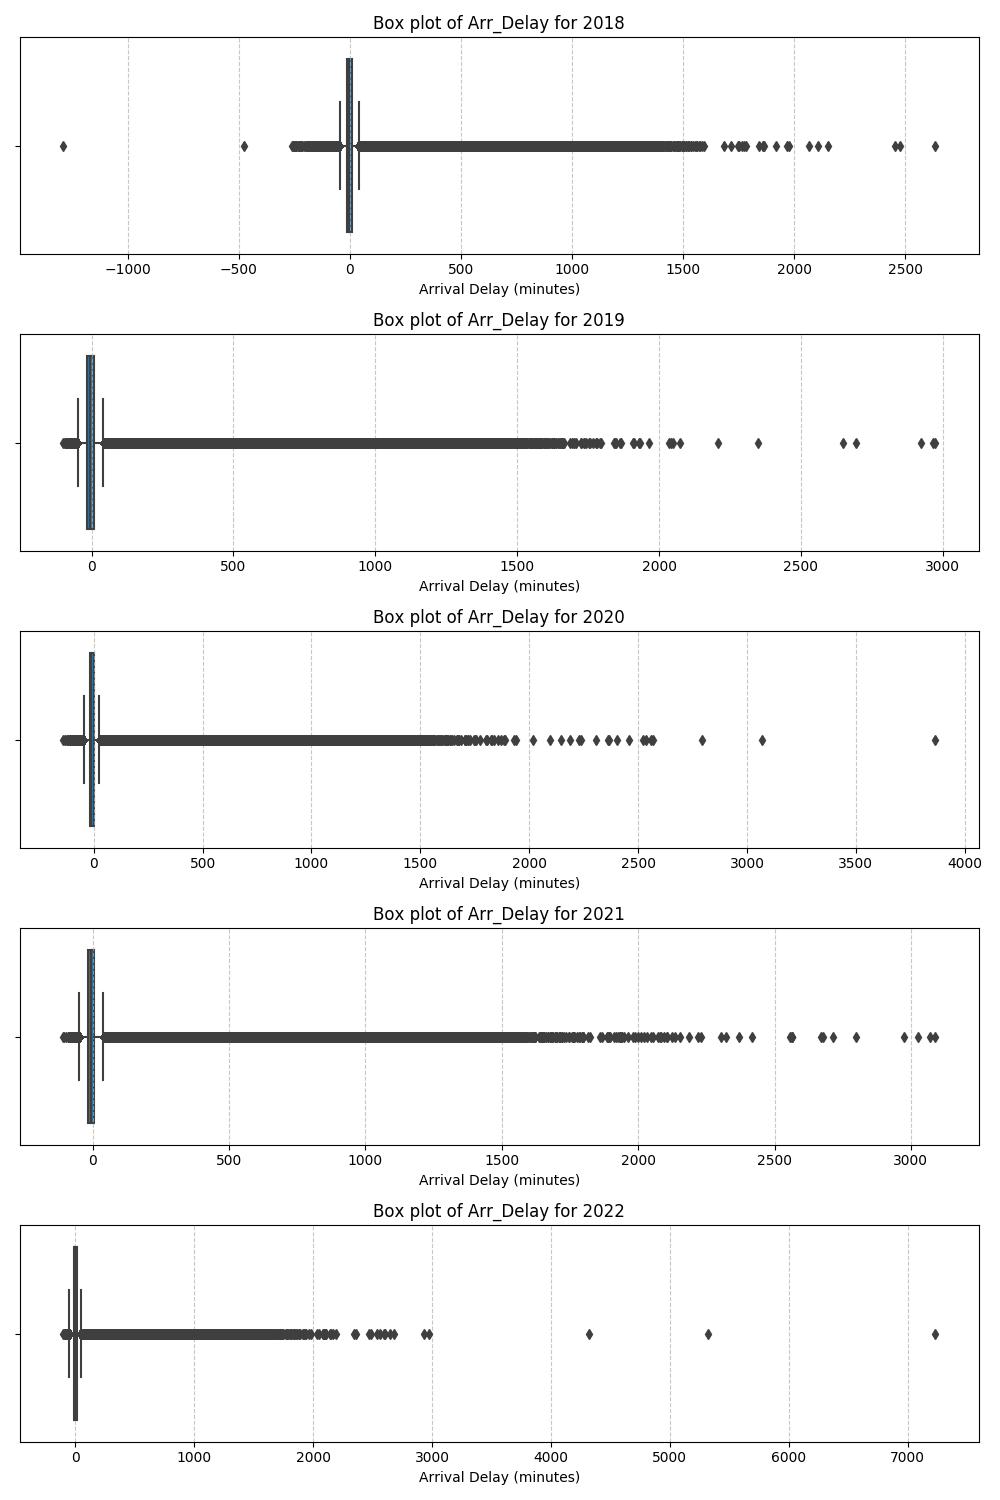

NameError: name 'plt' is not defined

In [23]:
%matplot plt
# Prepare for plotting
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

years = [arr_delay_2018, arr_delay_2019, arr_delay_2020, arr_delay_2021, arr_delay_2022]
year_labels = ['2018', '2019', '2020', '2021', '2022']

# Create a boxplot for each year
for i, year_data in enumerate(years):
    sns.boxplot(x=year_data["ArrDelay"], ax=axes[i])
    axes[i].set_title(f'Box plot of Arr_Delay for {year_labels[i]}')
    axes[i].set_xlabel('Arrival Delay (minutes)')
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)

# Ensure the layout is not overlapping
plt.tight_layout()
plt.show()

## Should we remove outliers?
- Ideally, we should consult a subject-matter expert to determine whether these extreme outliers are a result of human error or are actual occurrences.

- The longest delay of over 7000 minutes or 4.8 days may be possible in less developed countries, but in the context of the USA it is unlikely.

- We will further investigate the outliers.

In [24]:
# extract the top three outliers from each year

# Define a window specification ordered by ArrDelay in descending order
windowSpec = Window.orderBy(F.col("ArrDelay").desc())

def get_top3(df):
    """Return top 3 rows of df based on ArrDelay"""
    return (df.withColumn("rank", F.row_number().over(windowSpec))
            .filter(F.col("rank") <= 3)
            .select('FlightDate', 'Airline', 'OriginCityName', 'DestCityName', 'ArrDelay'))

# Apply the function on each year's dataframe and union the results
combined_top3 = (get_top3(df_2018)
                 .union(get_top3(df_2019))
                 .union(get_top3(df_2020))
                 .union(get_top3(df_2021))
                 .union(get_top3(df_2022)))

# Show the combined results
combined_top3.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+--------------------+--------------------+--------+
|FlightDate|             Airline|      OriginCityName|        DestCityName|ArrDelay|
+----------+--------------------+--------------------+--------------------+--------+
|2018-09-16|    Compass Airlines|       Las Vegas, NV|     Los Angeles, CA|  2635.0|
|2018-02-09|Hawaiian Airlines...|        Honolulu, HI|       Pago Pago, TT|  2475.0|
|2018-02-09|Hawaiian Airlines...|       Pago Pago, TT|        Honolulu, HI|  2454.0|
|2019-11-21|GoJet Airlines, L...|  Raleigh/Durham, NC|       Nashville, TN|  2973.0|
|2019-11-21|GoJet Airlines, L...|       Nashville, TN|  Raleigh/Durham, NC|  2965.0|
|2019-03-21|GoJet Airlines, L...|      Manchester, NH|         Detroit, MI|  2923.0|
|2020-07-17|American Airlines...|         Madison, WI|Dallas/Fort Worth...|  3864.0|
|2020-12-10|American Airlines...|Charlotte Amalie, VI|           Miami, FL|  3069.0|
|2020-02-19|American Airlines...|Charlotte Amalie, VI|       Char

### Future Work
- A possible avenue for exploration would be to verify that each of these flights were in fact delayed by that much.

- However, a Google Search is not sufficient to verify this.

- Hence we will give the data the benefit of the doubt and keep the outliers in. The fraction of extreme outliers are so small compared to the total dataset that their results will probably be negligable.

## Feature Engineering - FlightStatus Column

- We would like to add an extra categorical column called FlightStatus with the following categories:
    - On_Time_Early
    - Delayed_Moderate
    - Delayed_Serious
    - Cancelled



In [25]:
df_with_status_2018 = df_2018.withColumn("FlightStatus",
                               F.when(F.col("Cancelled") == True, "Cancelled")
                               .when((F.col("ArrDelay") > 10) & (F.col("ArrDelay") < 180), "Delayed_Moderate")
                               .when((F.col("ArrDelay") > 180), "Delayed_Serious_Diverted")
                               .otherwise("On_Time_Early"))

# To show the first few rows and see the new "FlightStatus" column:
df_with_status_2018.select("Cancelled", "ArrDelay", "Diverted", "FlightStatus").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------+--------+----------------+
|Cancelled|ArrDelay|Diverted|    FlightStatus|
+---------+--------+--------+----------------+
|    false|    -8.0|   false|   On_Time_Early|
|    false|    -6.0|   false|   On_Time_Early|
|    false|    -2.0|   false|   On_Time_Early|
|    false|   -11.0|   false|   On_Time_Early|
|    false|    -1.0|   false|   On_Time_Early|
|    false|    22.0|   false|Delayed_Moderate|
|    false|    -1.0|   false|   On_Time_Early|
|    false|    -9.0|   false|   On_Time_Early|
|    false|    null|   false|   On_Time_Early|
|    false|    22.0|   false|Delayed_Moderate|
|    false|   -12.0|   false|   On_Time_Early|
|    false|   -13.0|   false|   On_Time_Early|
|    false|   -10.0|   false|   On_Time_Early|
|    false|   -13.0|   false|   On_Time_Early|
|    false|    16.0|   false|Delayed_Moderate|
|    false|   105.0|   false|Delayed_Moderate|
|    false|   -11.0|   false|   On_Time_Early|
|    false|     8.0|   false|   On_Time_Early|
|    false|  

In [26]:
# count and group by fluight status, then convert to pandas
status_counts_2018 = df_with_status_2018.groupBy("FlightStatus").agg(F.count("*").alias("Count")).toPandas()
print(status_counts_2018)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

               FlightStatus    Count
0             On_Time_Early  4334662
1                 Cancelled    88373
2          Delayed_Moderate  1205671
3  Delayed_Serious_Diverted    60806

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

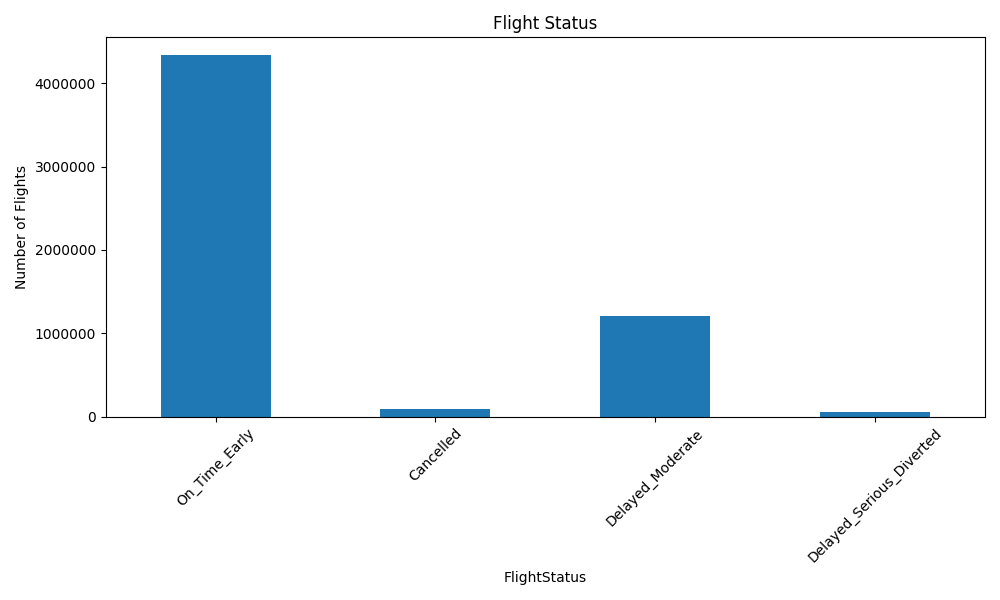

NameError: name 'status_counts_2018' is not defined

In [28]:
%matplot plt
# Bar chart
status_counts_2018.plot(kind='bar', x='FlightStatus', y='Count', legend=False, figsize=(10, 6))
plt.ylabel('Number of Flights')
plt.title('Flight Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
#Function to repeat data cleaning process
def create_flight_status_column(df):
    df_with_status = df.withColumn("FlightStatus",
                               F.when(F.col("Cancelled") == True, "Cancelled")
                               .when((F.col("ArrDelay") > 10) & (F.col("ArrDelay") < 180), "Delayed_Moderate")
                               .when((F.col("ArrDelay") > 180), "Delayed_Serious_Diverted")
                               .otherwise("On_Time_Early"))
    return df_with_status

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Analysing Distribution of Other Years


In [15]:
augmented_2018 = create_flight_status_column(df_2018)
augmented_2019 = create_flight_status_column(df_2019)
augmented_2020 = create_flight_status_column(df_2020)
augmented_2021 = create_flight_status_column(df_2021)
augmented_2022 = create_flight_status_column(df_2022)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
#aggregate the data
years = [2018,2019, 2020, 2021, 2022]
dfs = [augmented_2018, augmented_2019, augmented_2020, augmented_2021, augmented_2022]  # Assuming you have separate DataFrames for each year

status_counts_by_year = {}

for year, df_year in zip(years, dfs):
    status_counts_by_year[year] = df_year.groupBy("FlightStatus").agg(F.count("*").alias("Count")).toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

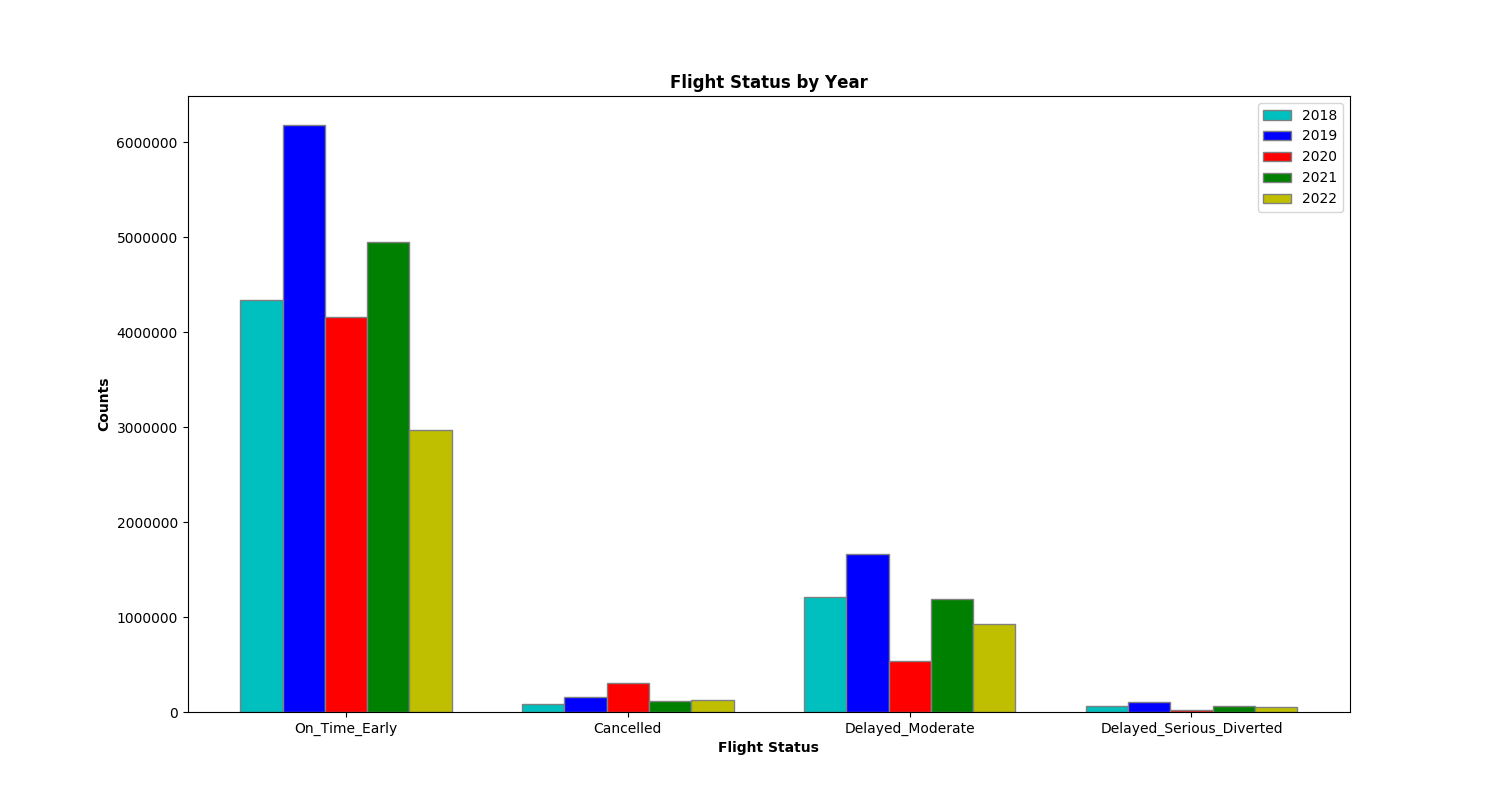

NameError: name 'np' is not defined

In [33]:
%matplot plt

barWidth = 0.15  # Adjusted the bar width for more bars
r1 = np.arange(len(status_counts_by_year[2018]))  # Positions for the 2018 bars
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

plt.figure(figsize=(15, 8))

# Plot bars for each year
plt.bar(r1, status_counts_by_year[2018]['Count'], color='c', width=barWidth, edgecolor='grey', label='2018')
plt.bar(r2, status_counts_by_year[2019]['Count'], color='b', width=barWidth, edgecolor='grey', label='2019')
plt.bar(r3, status_counts_by_year[2020]['Count'], color='r', width=barWidth, edgecolor='grey', label='2020')
plt.bar(r4, status_counts_by_year[2021]['Count'], color='g', width=barWidth, edgecolor='grey', label='2021')
plt.bar(r5, status_counts_by_year[2022]['Count'], color='y', width=barWidth, edgecolor='grey', label='2022')

# Title & Subtitle
plt.title('Flight Status by Year', fontweight='bold')
plt.xlabel('Flight Status', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')

# Add xticks on the middle of the group bars
plt.xticks([r + 2*barWidth for r in range(len(status_counts_by_year[2018]))], status_counts_by_year[2018]['FlightStatus'])

# Create legend & Show graphic
plt.legend()
plt.show()

## Observation: Many more cancelled flights in 2020
- It can be seen that there is a disproprtionately large number of cancellations in 2020.

- This is probably due to travel restrictions imposed, causing travel demand to tank.

- In the first part of the analysis - finding the relationship between airlines and cancellations, we will leave it as it is, since the pandemic would have affected the entire aviation industry in around the same way-especially since the travel restrictions imposed by the US government was the same across the US in 2020. (In real life a subject matter expert should be consulted in this decision).

- Later when building the model to predict flight cancellations, we may omit 2020, or omit 2018 and 2019, since those years no longer reflect the post-Covid recovery seen by the aviation industry.

## Analysing all 4 years as a whole

In [17]:
# Combine the Data from all years
dfs = [augmented_2018, augmented_2019, augmented_2020, augmented_2021, augmented_2022]
combined_df = dfs[0]

for df in dfs[1:]:
    combined_df = combined_df.union(df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
# FlightStatus distribution
status_counts = combined_df.groupBy("FlightStatus").agg(F.count("*").alias("Count")).toPandas()
print(status_counts)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

               FlightStatus     Count
0             On_Time_Early  22589153
1                 Cancelled    777267
2          Delayed_Moderate   5525965
3  Delayed_Serious_Diverted    301397

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

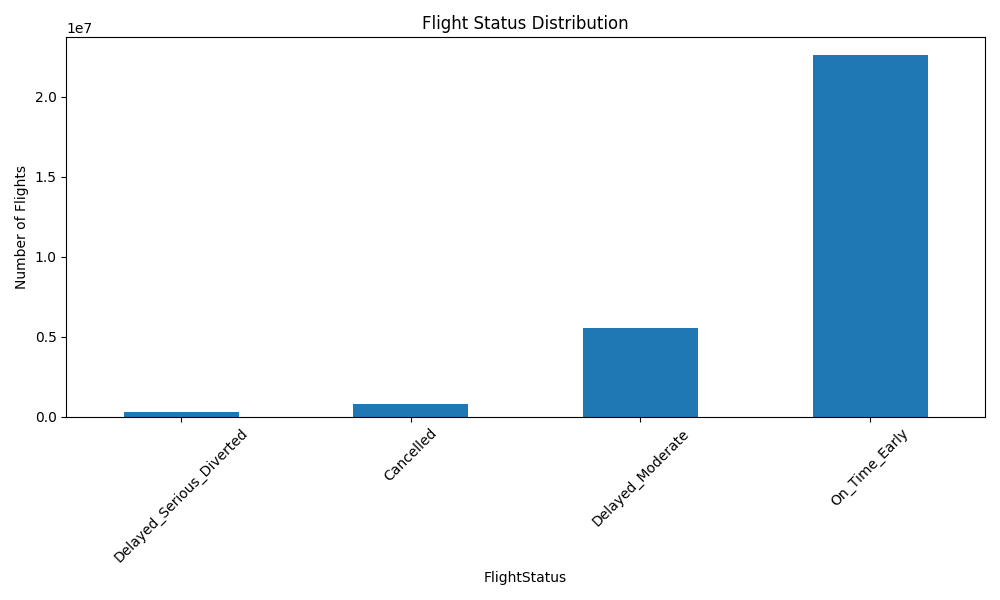

NameError: name 'status_counts' is not defined

In [37]:
%matplot plt
status_counts.sort_values('Count').plot(kind='bar', x='FlightStatus', y='Count', legend=False, figsize=(10, 6))
plt.ylabel('Number of Flights')
plt.title('Flight Status Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Remove Diverted Flights
In the following sectionwe will remove all diverted flights since under the current labelling, they would be grouped under `On_Time_Early`

Also we are not told to predict diverted flights, so leaving them in the dataset would not be useful. 

In [18]:
# remove all the diverted aircraft
filtered_df = combined_df.filter(combined_df.Diverted == False)
filtered_df = filtered_df.withColumn("FlightStatus", 
                                     F.when(filtered_df["FlightStatus"] == "Delayed_Serious_Diverted", "Delayed_Serious")
                                     .otherwise(filtered_df["FlightStatus"]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Investigating the Relationship between Airline and FlightStatus

In [39]:
#Frequency distribution of airlines:
filtered_df.groupBy("Airline").count().orderBy("count", ascending=False).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+
|             Airline|  count|
+--------------------+-------+
|Southwest Airline...|5463999|
|Delta Air Lines Inc.|3288875|
|SkyWest Airlines ...|3149885|
|American Airlines...|3126333|
|United Air Lines ...|2348429|
|   Republic Airlines|1280760|
|     JetBlue Airways|1102555|
|           Envoy Air|1070102|
|   Endeavor Air Inc.| 996457|
|         Comair Inc.| 954742|
|Alaska Airlines Inc.| 904028|
|    Spirit Air Lines| 835109|
|  Mesa Airlines Inc.| 747336|
|Frontier Airlines...| 569657|
|       Allegiant Air| 487992|
|         Horizon Air| 470049|
|Capital Cargo Int...| 390848|
|Air Wisconsin Air...| 379384|
|ExpressJet Airlin...| 352599|
|Hawaiian Airlines...| 310504|
+--------------------+-------+
only showing top 20 rows

In [40]:
# Plot Distribution of FlightStatus by Airlines
status_airline_df = filtered_df.groupBy("Airline", "FlightStatus").count().orderBy("Airline", "count", ascending=[1, 0]).toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

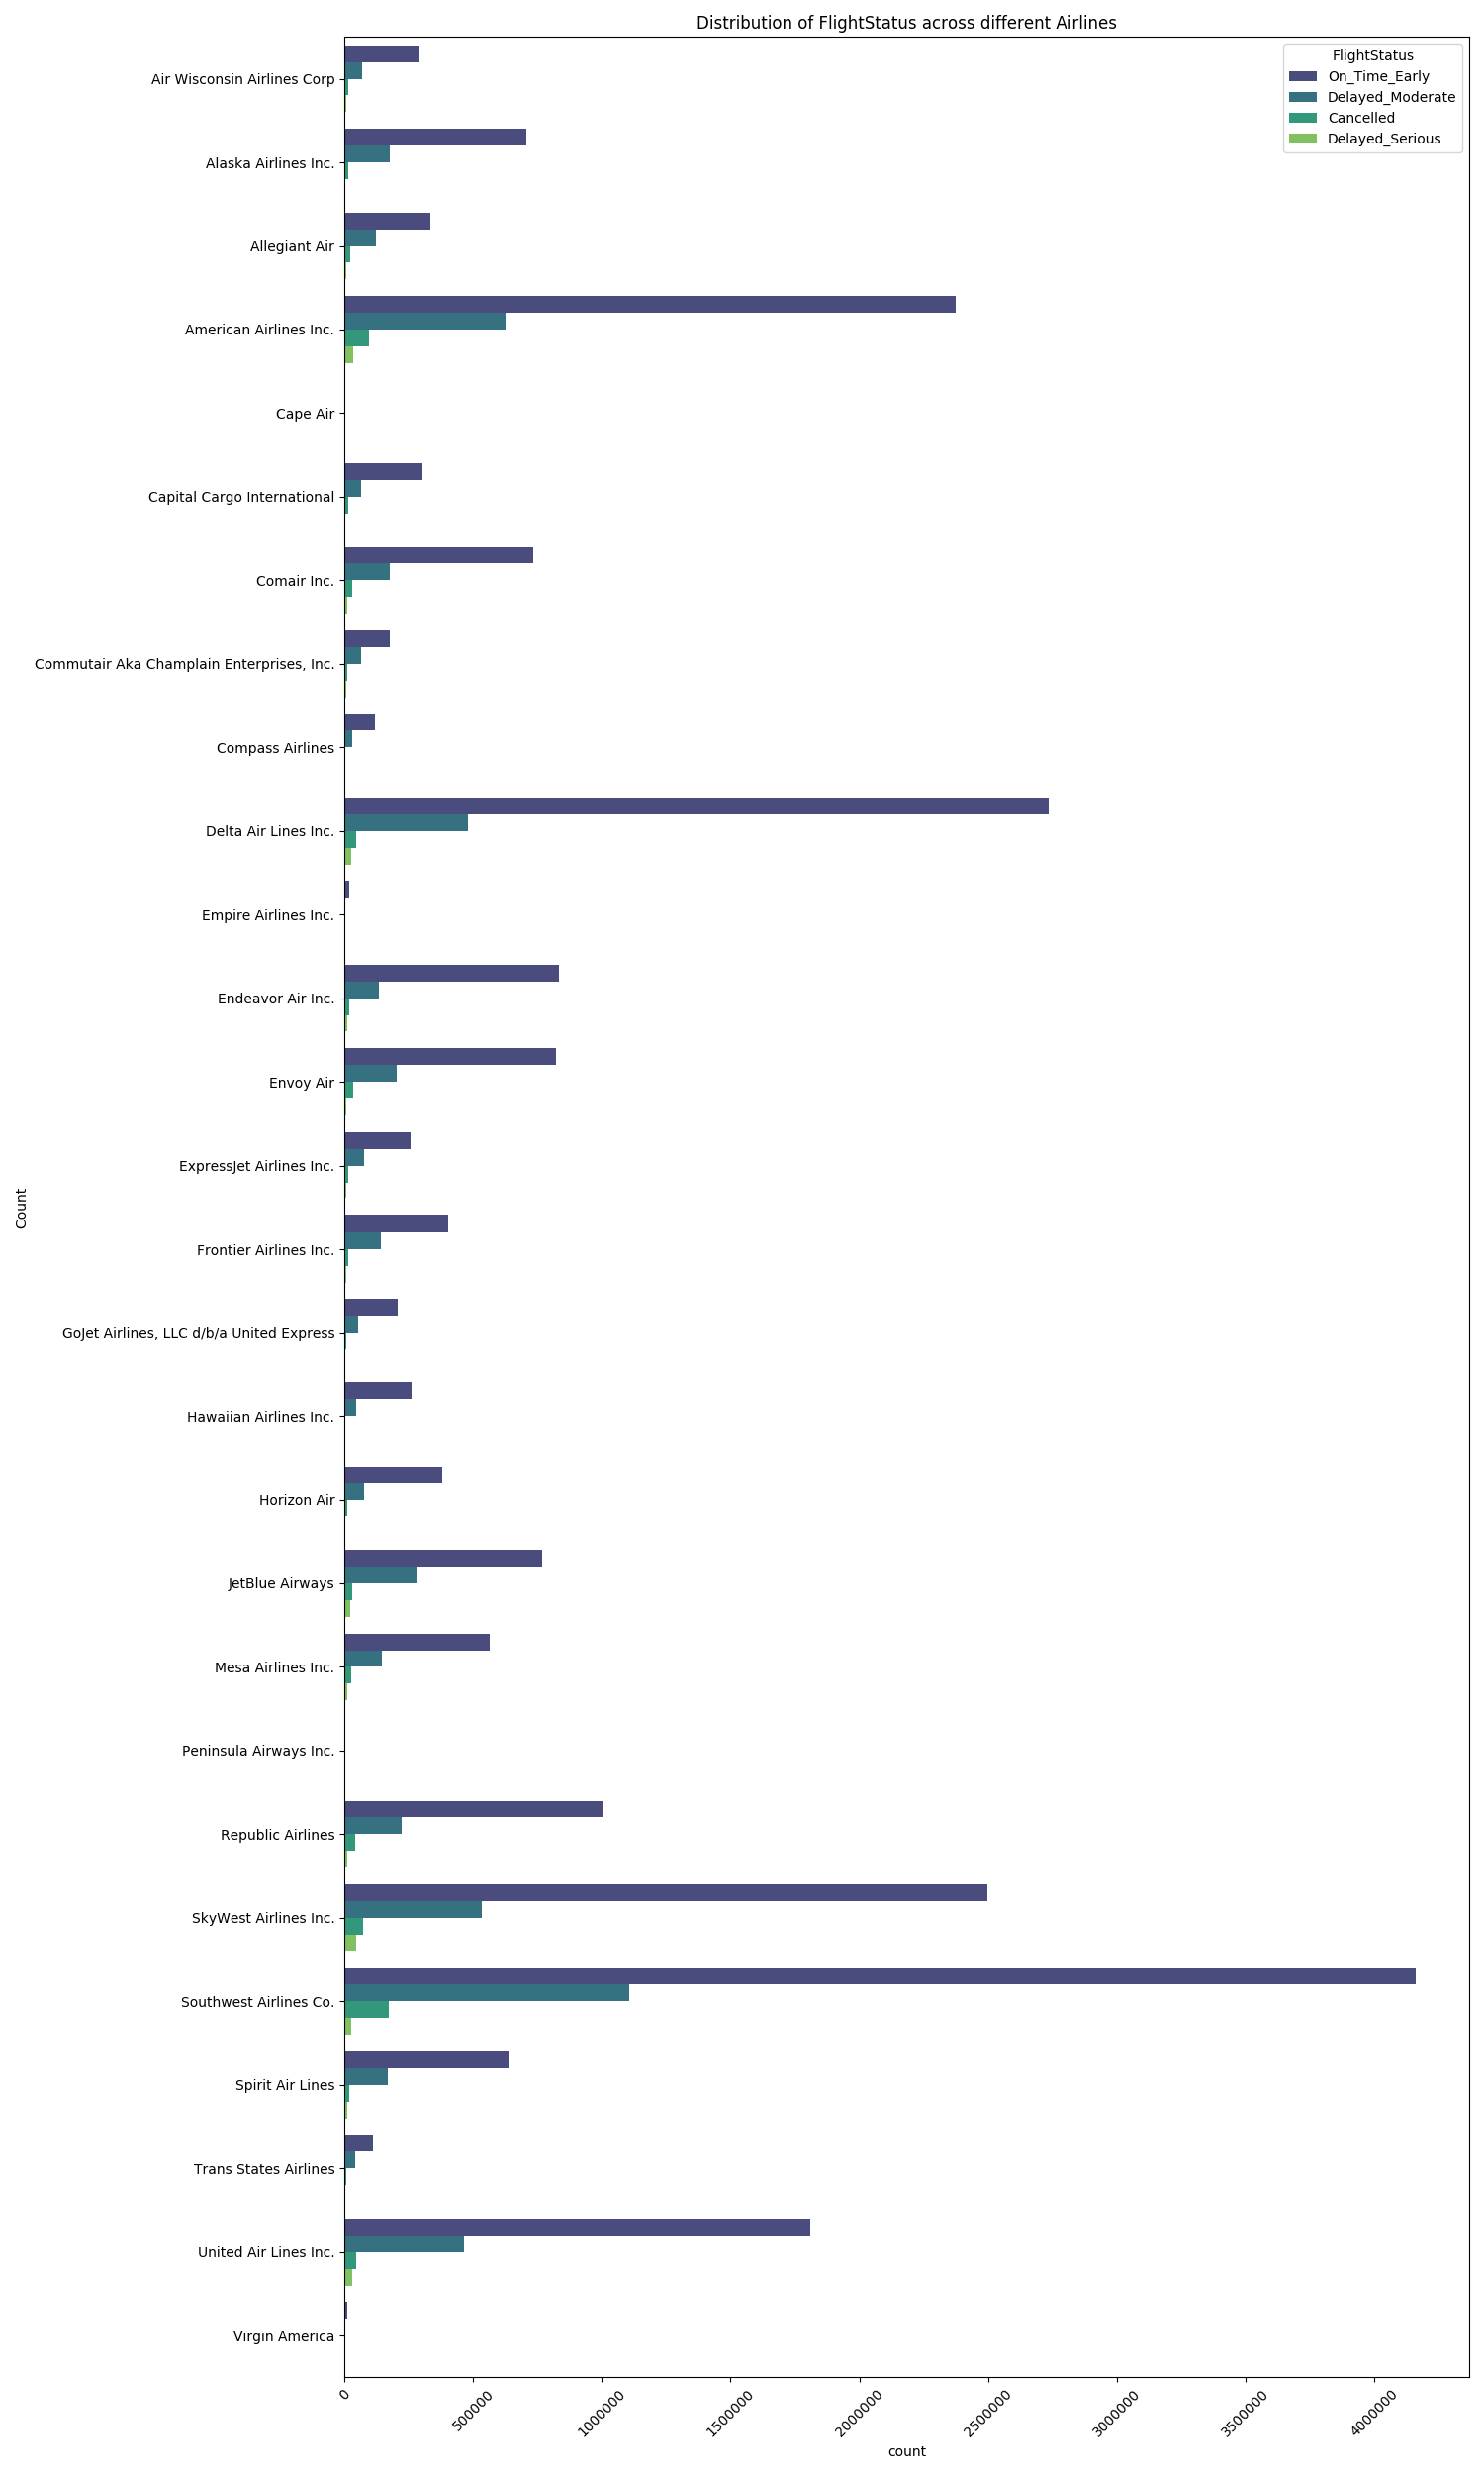

NameError: name 'plt' is not defined

In [42]:
%matplot plt
# Set up the figure and axis
plt.figure(figsize=(15,25))
sns.barplot(data=status_airline_df, y='Airline', x='count', hue='FlightStatus', palette='viridis')

# Rotate x labels for better visibility
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Distribution of FlightStatus across different Airlines')
plt.tight_layout()

# Display the plot
plt.show()

## Feature Engineering: Proportion of On-Time Flights to Total Flights
- The above plot does not really give a sense of how 'good' or 'bad an airline actually is. 

- For example, Southwest has the most number of delayed flights but that could just be because they have a lot more flights than everyone else.

- We will now find the proportion of on time flights for each airline

In [43]:
# 1. Calculate total number of flights for each airline
total_flights_per_airline = filtered_df.groupBy("Airline").agg(F.sum(F.when(F.col("FlightStatus") == "On_Time_Early", 1).otherwise(0)).alias("On_Time_Count"),
                                                              F.count("*").alias("Total_Flights"))

# 2. Calculate the proportion of On_Time flights to total flights
on_time_proportion = total_flights_per_airline.withColumn("On_Time_Proportion", F.col("On_Time_Count") / F.col("Total_Flights"))

#3. convert to pandas df
on_time_proportion_pd = on_time_proportion.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

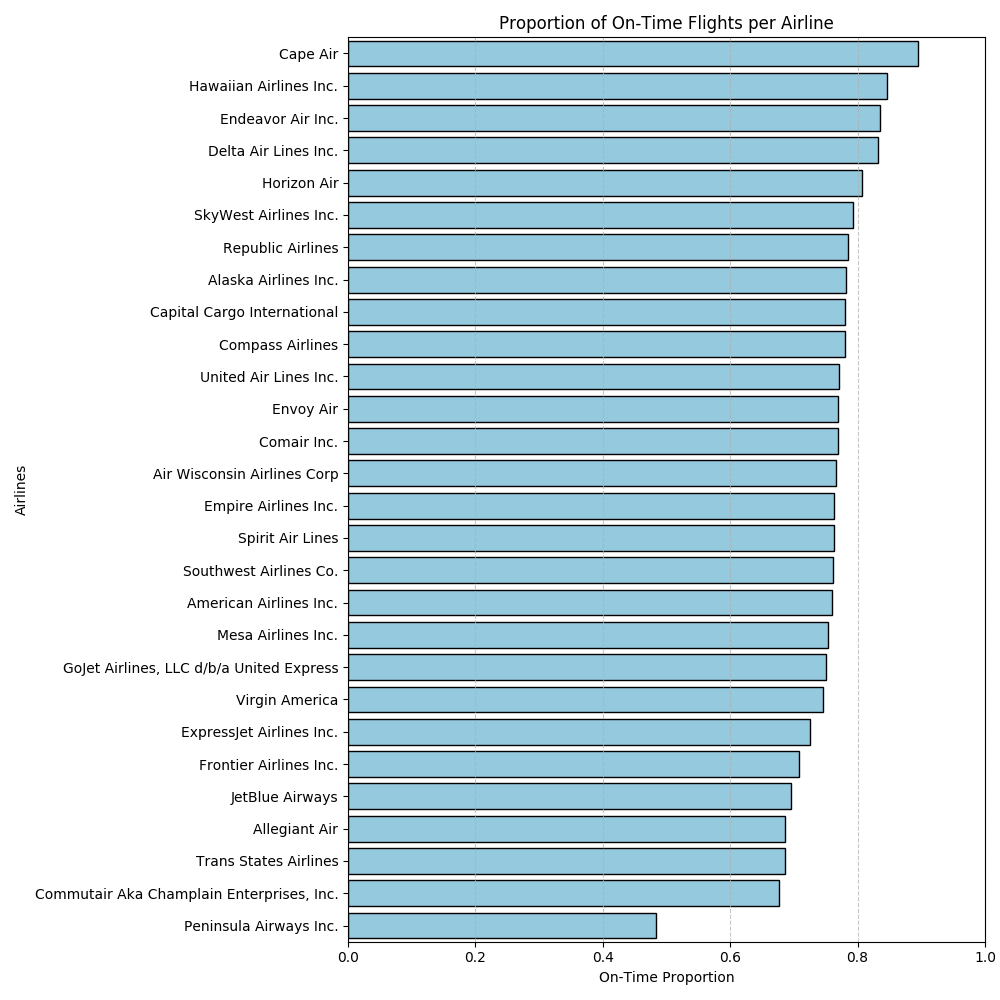

NameError: name 'plt' is not defined

In [45]:
%matplot plt
plt.figure(figsize=(10,10))
sns.barplot(data=on_time_proportion_pd.sort_values(by='On_Time_Proportion', ascending=False), y='Airline', x='On_Time_Proportion', color='skyblue', edgecolor='black')

plt.xlabel('On-Time Proportion')
plt.ylabel('Airlines')
plt.title('Proportion of On-Time Flights per Airline')
plt.tight_layout()
plt.xlim(0, 1)  # To make sure the x-axis is between 0 and 1, representing proportions
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional: Add a grid for better readability

plt.show()

## Observing the Changes in On-Time Performance By Year


In [49]:
# Calculate total number of flights for each airline for each year
total_flights_per_airline_year = filtered_df.groupBy("Airline", "Year").agg(
    F.sum(F.when(F.col("FlightStatus") == "On_Time_Early", 1).otherwise(0)).alias("On_Time_Count"),
    F.count("*").alias("Total_Flights")
)

# Calculate the proportion of On_Time flights to total flights for each year
on_time_proportion_year = total_flights_per_airline_year.withColumn("On_Time_Proportion", F.col("On_Time_Count").cast("float") / F.col("Total_Flights"))

# Convert this DataFrame to Pandas for visualization
on_time_proportion_year_pd = on_time_proportion_year.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

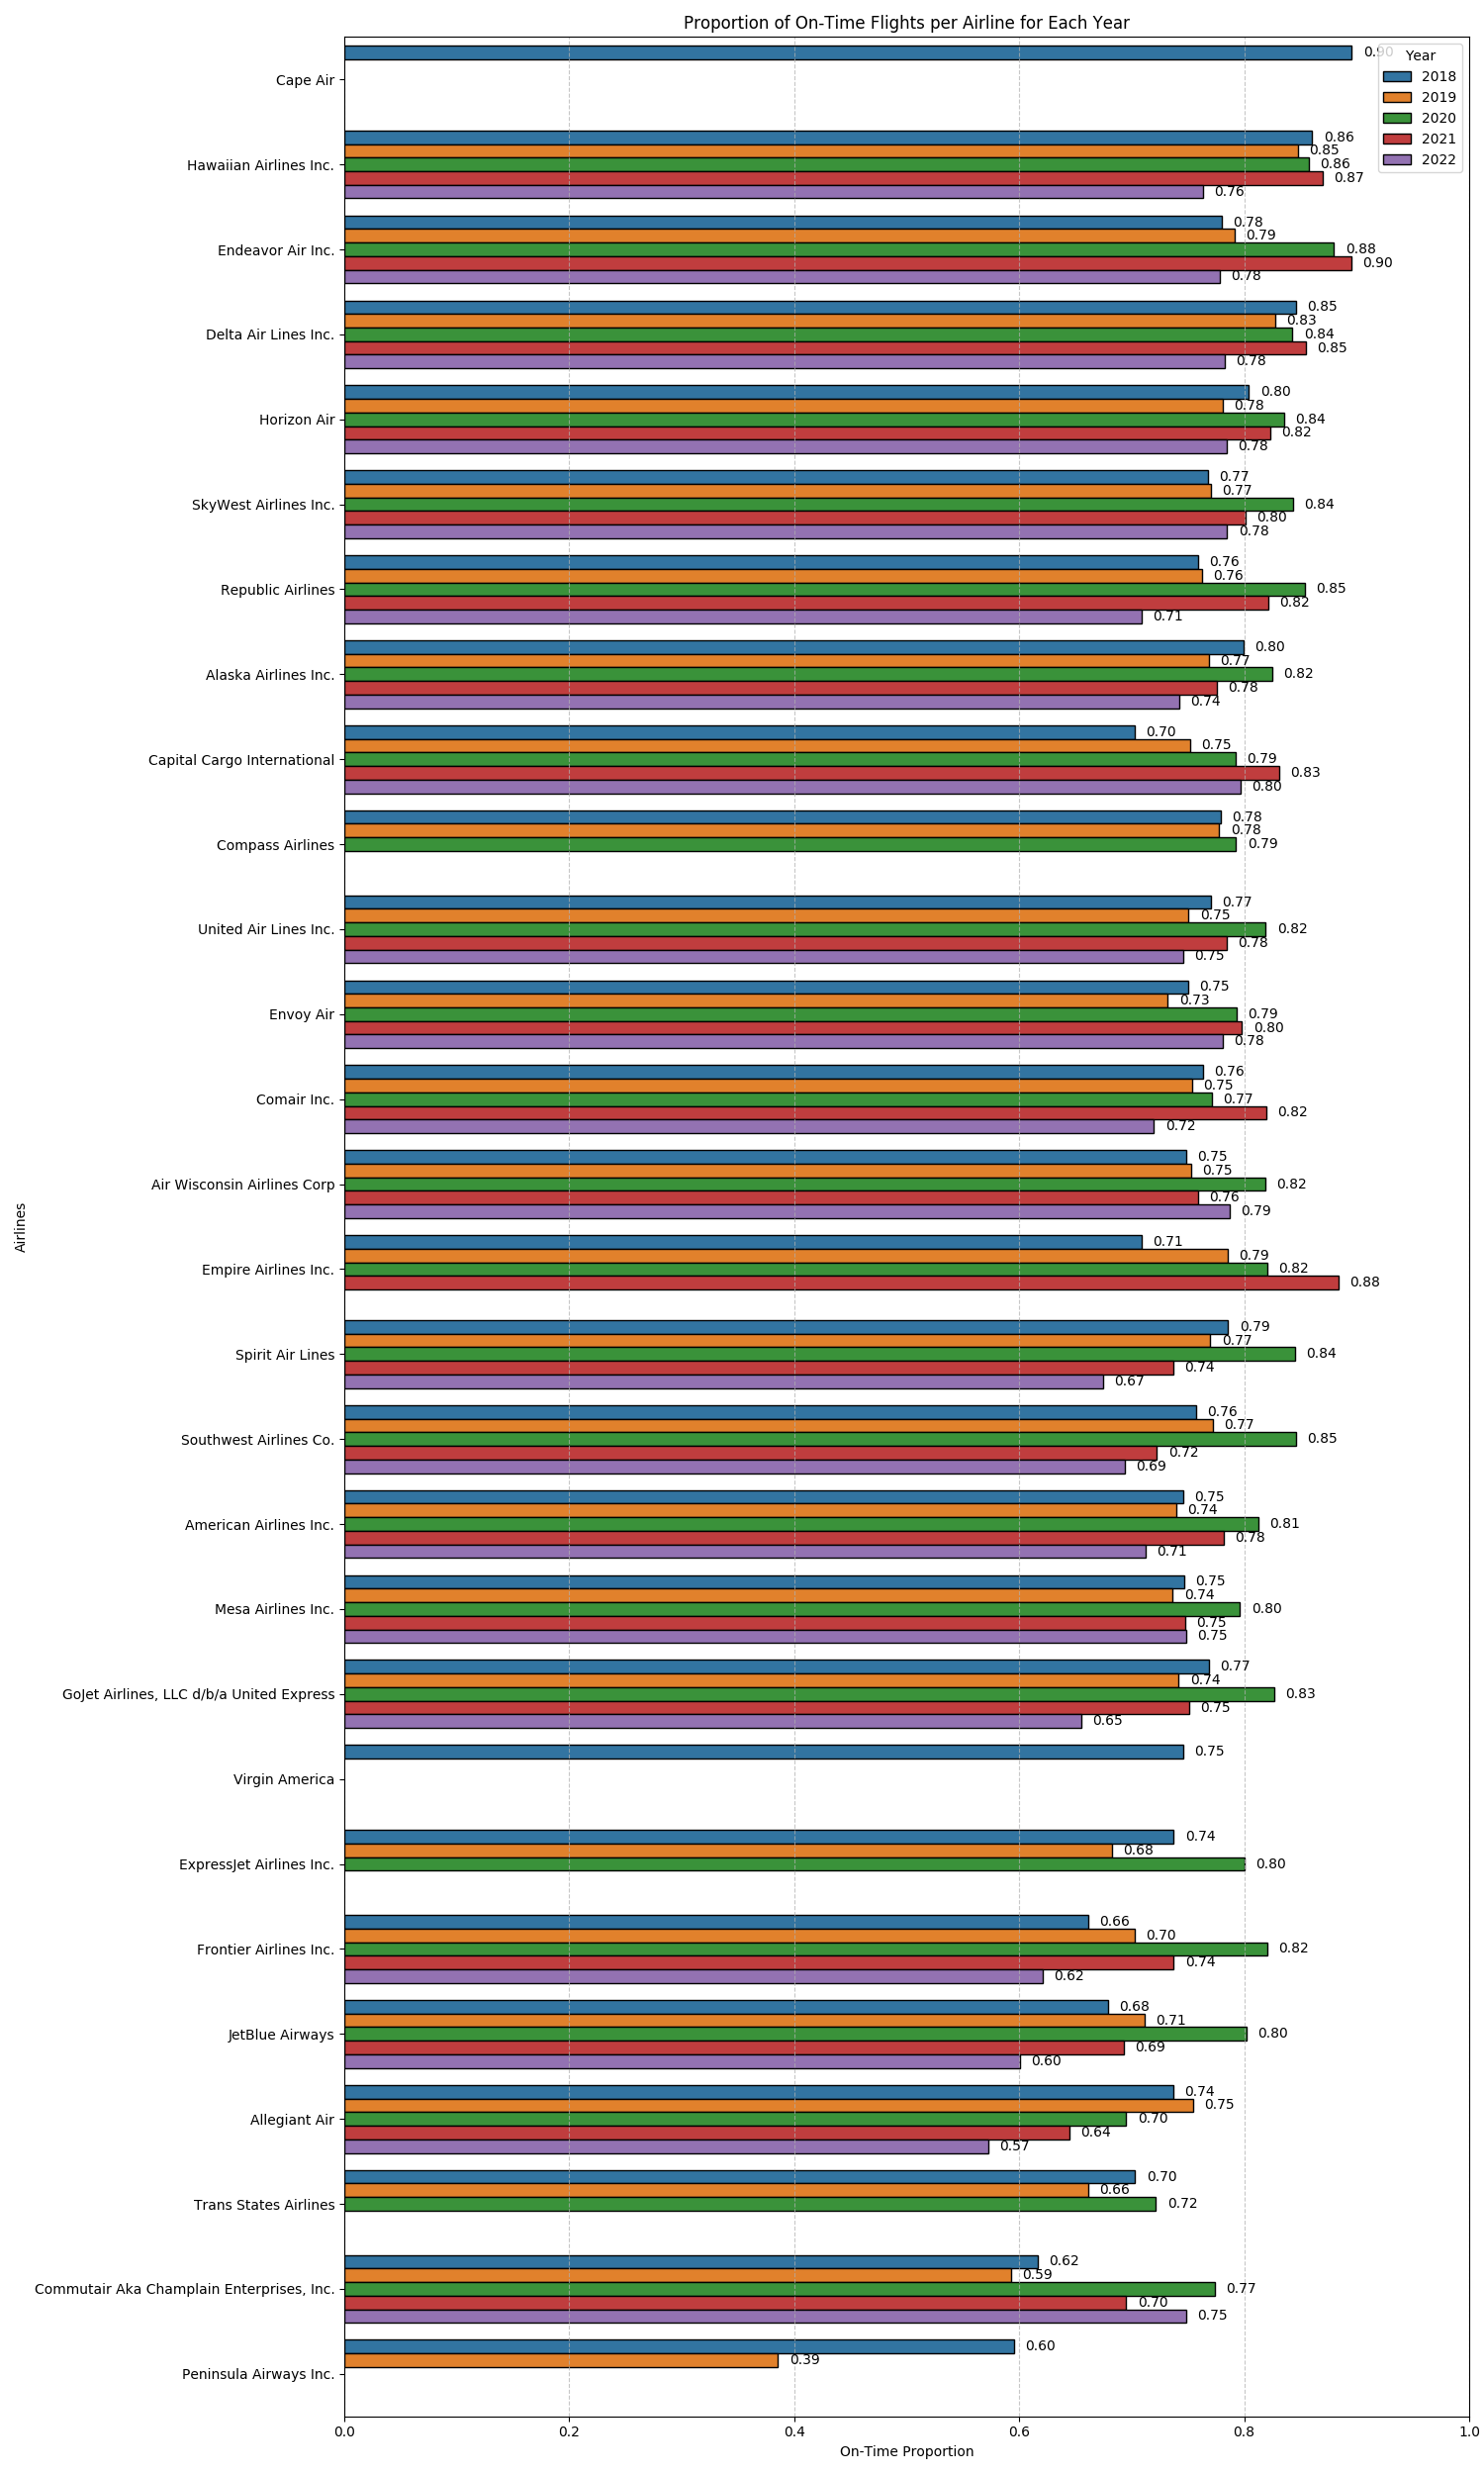

NameError: name 'on_time_proportion_pd' is not defined

In [48]:
%matplot plt
#get the order of the plots from the previous graph
order_airlines = on_time_proportion_pd.sort_values(by='On_Time_Proportion', ascending=False)['Airline'].tolist()

# Plot figure
plt.figure(figsize=(15, 25))
ax = sns.barplot(data=on_time_proportion_year_pd, y='Airline', x='On_Time_Proportion', hue='Year', edgecolor='black',
           order = order_airlines)

# Annotate each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01,        # set the text at 1 unit right of the bar
             p.get_y() + p.get_height() / 2,  # get Y coordinate + X coordinate / 2
             '{:1.2f}'.format(width),       # set variable to display, 2 decimals
             ha="left",                      # horizontal alignment
             va="center")                    # vertical alignment

plt.xlabel('On-Time Proportion')
plt.ylabel('Airlines')
plt.title('Proportion of On-Time Flights per Airline for Each Year')
plt.tight_layout()
plt.xlim(0, 1)  # To ensure the x-axis is between 0 and 1, representing proportions
plt.legend(title="Year", loc="upper right")
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional: Add a grid for better readability

plt.show()

### Observation: Hawaiian takes the cake
- Cape Air has the highest proportion of On-Time flights. However, after considering the plot by year we can see that the airline stopped operating after 2018.

- Hence, it can be said that the airline with the best On-Time performance over the 5-year period (that is still operating) is **Hawaiian Airlines**.

- The worst performing airline was Peninsula Airways, but it has also ceased operations. Hence the worst On-time performance (for an airline that is still operating) is Commutair.

# Relationship Between Travel Date and Cancellations

In [50]:
# Assign a very high value for Cancelled records, else use ArrDelay value
df_with_values = filtered_df.withColumn("heatmap_value", 
                                        F.when(F.col("Cancelled") == True, 5e4).otherwise(F.col("ArrDelay")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
#count the number of nulls in heatmap_value
null_count = df_with_values.filter(F.col("heatmap_value").isNull()).count()
print(null_count)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

569

In [52]:
df_with_values = df_with_values.filter(F.col("heatmap_value").isNotNull())

# Aggregate values by date
daily_data = (df_with_values.groupBy("FlightDate")
              .agg(F.mean("heatmap_value").alias("avg_delay"))
              .orderBy("FlightDate"))
# Convert to Pandas
daily_data_pd = daily_data.toPandas()
daily_data_pd['FlightDate'] = pd.to_datetime(daily_data_pd['FlightDate'])
daily_data_pd.set_index('FlightDate', inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

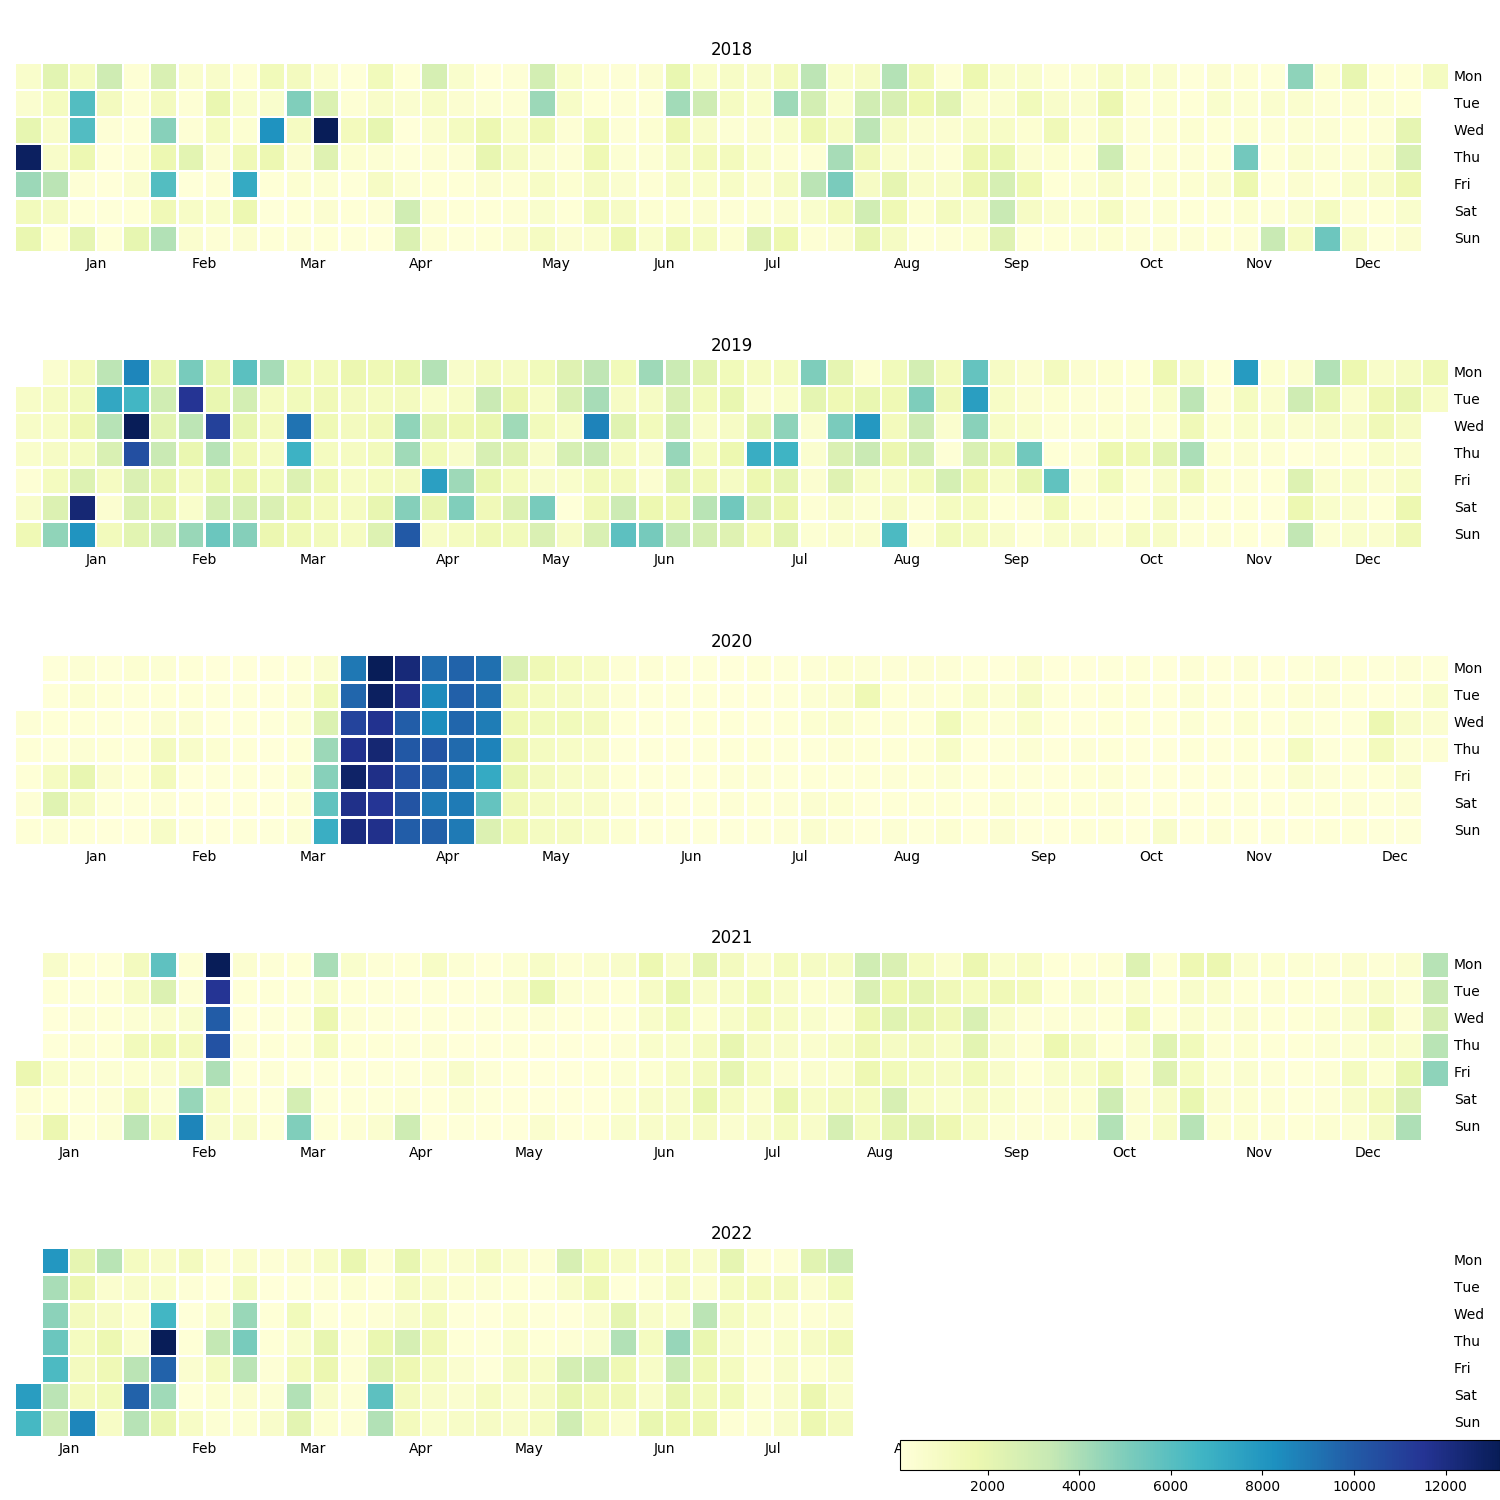

NameError: name 'daily_data_pd' is not defined

In [54]:
%matplot plt
# Assuming daily_data_pd has the data with FlightDate as the index
daily_data_pd['Year'] = daily_data_pd.index.year

years = daily_data_pd['Year'].unique()

fig, axes = plt.subplots(nrows=len(years), figsize=(15, 3*len(years)))  # Adjust the size if needed

for i, year in enumerate(years):
    yearly_data = daily_data_pd[daily_data_pd['Year'] == year]
    
    # If there's only one year of data, axes won't be an array, so handle that case
    ax = axes[i] if len(years) > 1 else axes
    
    # Draw the heatmap calendar
    last_map = calmap.yearplot(yearly_data['avg_delay'], year=year, ax=ax, cmap='YlGnBu', fillcolor='white')
    
    #label each year
    ax.set_title(str(year))
    
cbar_ax = fig.add_axes([0.6, 0.02, 0.4, 0.02])  
fig.colorbar(last_map.get_children()[1], cax=cbar_ax, orientation='horizontal')

plt.tight_layout()
plt.show()

## Observation: 2020 is not a normal year
- As discussed earlier, 2020 being the year of the pandemic has made it quite the anomaly.

- Especially in March and April. We wee that there is a chunk of dates between March and mid April 2020 where there was a much higher number of cancellations. (Extreme values of blue indicate a high proportion of cancellations).

- We may want to exclude 2020 from our analysis due to its anomolous nature

## That was a biased visualisation: Cancellations and Delays are Different
- Previously we treated cancellations and delays as a continuous scale. Doing this provides a way of **showing cancellations and delays on the same plot**, but doing that causes loss of information and can **skew the visualisation**. Hence, we will instead plot them separately.

- Also, randomly assigning a large number to represent Cancellation on the colour scale is arbitrary and is **introducing bias into the plot's colour scale**!

### Plotting Delays Against Time

In [55]:
df_delay_only = filtered_df.filter(F.col("Cancelled") != True)
df_delay_only = df_delay_only.filter(F.col("ArrDelay").isNotNull())

# Aggregate values by date
daily_data = (df_delay_only.groupBy("FlightDate")
              .agg(F.mean("ArrDelay").alias("avg_delay"))
              .orderBy("FlightDate"))
# Convert to Pandas
daily_data_pd = daily_data.toPandas()
daily_data_pd['FlightDate'] = pd.to_datetime(daily_data_pd['FlightDate'])
daily_data_pd.set_index('FlightDate', inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

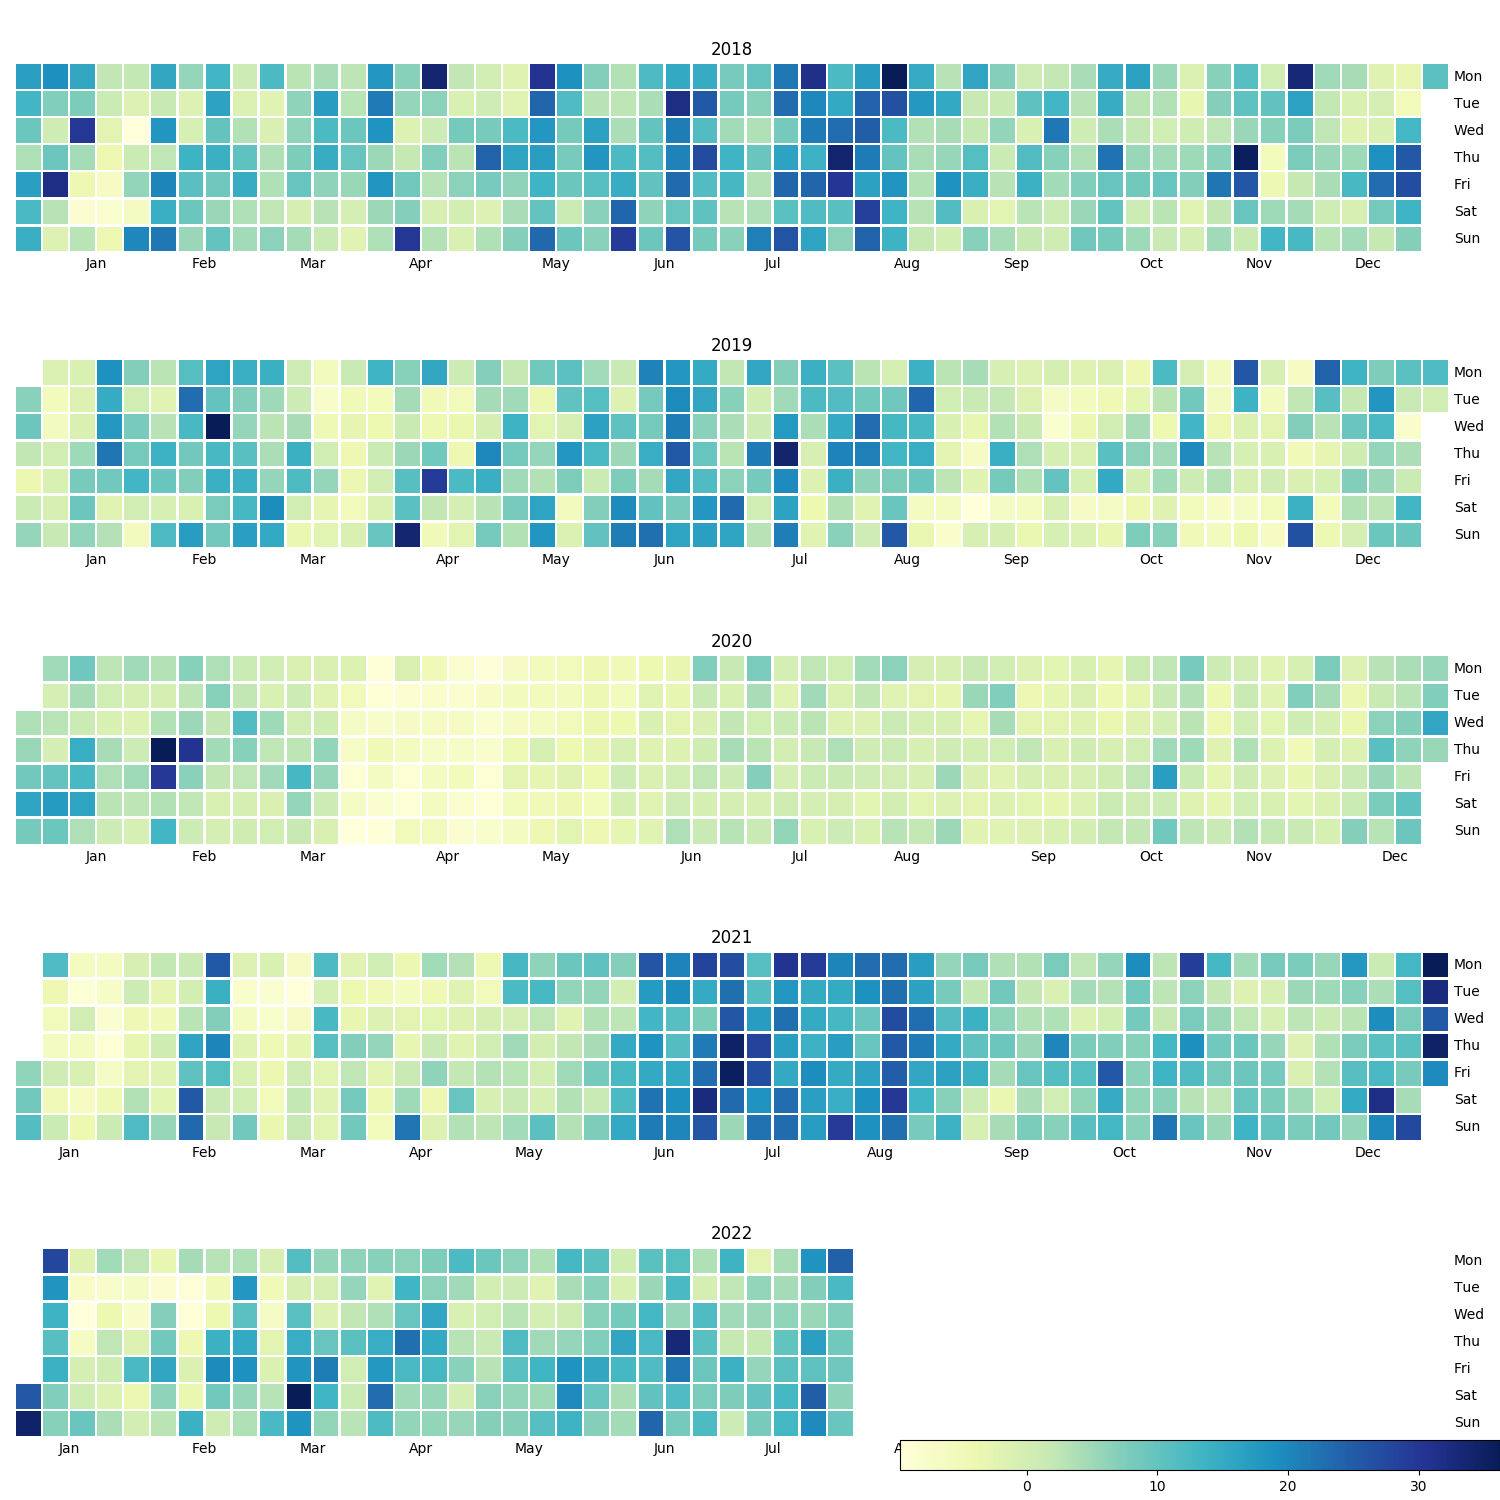

NameError: name 'daily_data_pd' is not defined

In [57]:
%matplot plt
# Assuming daily_data_pd has the data with FlightDate as the index
daily_data_pd['Year'] = daily_data_pd.index.year

years = daily_data_pd['Year'].unique()

fig, axes = plt.subplots(nrows=len(years), figsize=(15, 3*len(years)))  # Adjust the size if needed

for i, year in enumerate(years):
    yearly_data = daily_data_pd[daily_data_pd['Year'] == year]
    
    # If there's only one year of data, axes won't be an array, so handle that case
    ax = axes[i] if len(years) > 1 else axes
    
    # Draw the heatmap calendar
    last_map = calmap.yearplot(yearly_data['avg_delay'], year=year, ax=ax, cmap='YlGnBu', fillcolor='white')
    
    #label each year
    ax.set_title(str(year))
    
cbar_ax = fig.add_axes([0.6, 0.02, 0.4, 0.02])  
fig.colorbar(last_map.get_children()[1], cax=cbar_ax, orientation='horizontal')

plt.tight_layout()
plt.show()

### Observation: More Delays in Summer Months, Less in March
- In every year, it can be observed that there is an increase in average delays between June and August, with the exception of 2020.

- This could possibly be due to the summer holidays, causing an increase in demand.

- In March there are fewer holidays in the US, which may translate to less demand and less congestion at airports. The weather in March is also milder than Jan/Feb.

### Observation: Unusually High Level of Delays in 2021
- This is possibly due to the resurgence of air travel after the easing of restrictions in the US post-Covid. 

- The [spike in air travel](https://www.reuters.com/world/us/us-prepares-summer-air-travel-spike-weighs-foreign-changes-2021-05-25/) put pressure on airlines, who had to take fleet out of cold storage and rehire crew after the pandemic.

### Plotting Cancellations Against Time

In [58]:
df_cancelled_only = filtered_df.filter(F.col("Cancelled") == True)

daily_data_cancel = (df_cancelled_only.groupBy("FlightDate")
              .agg(F.sum(F.when(F.col("Cancelled") == True, 1).otherwise(0)).alias("num_cancellations"))
              .orderBy("FlightDate"))

# Convert to Pandas
daily_data_cancel_pd = daily_data_cancel.toPandas()
daily_data_cancel_pd['FlightDate'] = pd.to_datetime(daily_data_cancel_pd['FlightDate'])
daily_data_cancel_pd.set_index('FlightDate', inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

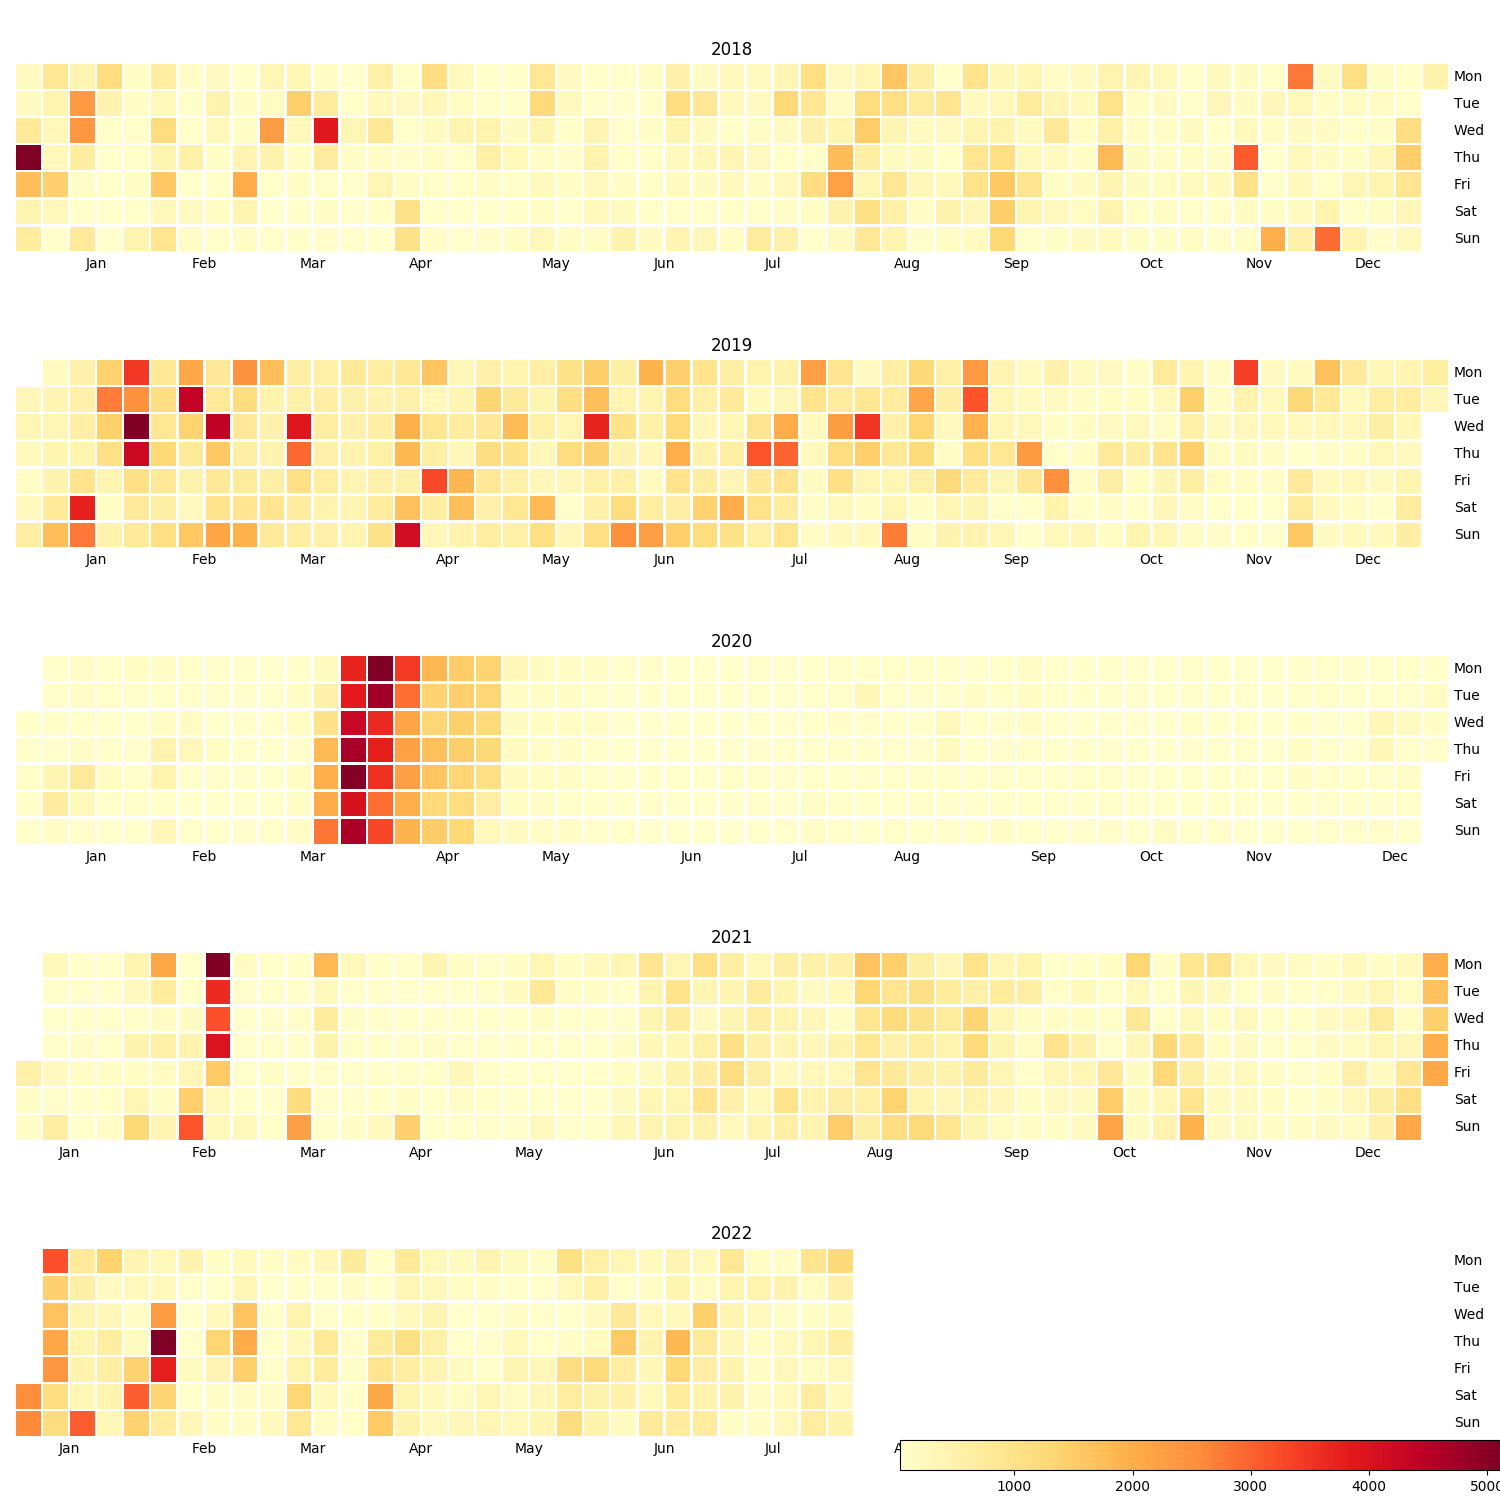

NameError: name 'daily_data_pd' is not defined

In [60]:
%matplot plt
# Assuming daily_data_pd has the data with FlightDate as the index
daily_data_cancel_pd['Year'] = daily_data_pd.index.year

years = daily_data_cancel_pd['Year'].unique()

fig, axes = plt.subplots(nrows=len(years), figsize=(15, 3*len(years)))  # Adjust the size if needed

for i, year in enumerate(years):
    yearly_data = daily_data_cancel_pd[daily_data_cancel_pd['Year'] == year]
    
    # If there's only one year of data, axes won't be an array, so handle that case
    ax = axes[i] if len(years) > 1 else axes
    
    # Draw the heatmap calendar
    last_map = calmap.yearplot(yearly_data["num_cancellations"], year=year, ax=ax, cmap='YlOrRd', fillcolor='white')
    
    #label each year
    ax.set_title(str(year))
    
cbar_ax = fig.add_axes([0.6, 0.02, 0.4, 0.02])  
fig.colorbar(last_map.get_children()[1], cax=cbar_ax, orientation='horizontal')

plt.tight_layout()
plt.show()

### Observation: More delays in Christmas/New Year until February

- This may be caused by weather during the harsher winter months, when snow storms and extreme weather is more common.

- To confirm this hypothesis, weather should be gathered and as well and tested with cancellations.

# Relationship between Origin State and Origin City and Cancellations
- In this section we will explore the relationships between geographical location and cancellations.

In [87]:
#Compute the number of cancellations and total flights for each airport 

#convert cancellation to int type
airport_aggregated_cancellations = combined_df.groupBy("OriginCityName").agg(
    F.count("*").alias("total_flights"),
    F.sum(F.when(F.col("Cancelled") == True, 1).otherwise(0)).alias("cancelled_flights")
)

#compute cancellation rate
airport_aggregated_cancellations = airport_aggregated_cancellations.withColumn(
    "cancellation_rate", F.col("cancelled_flights") / F.col("total_flights")
)

#find the top 30 airports with highest cancellation rates
top_cancellation_airports = airport_aggregated_cancellations.orderBy(F.desc("cancellation_rate")).limit(30)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

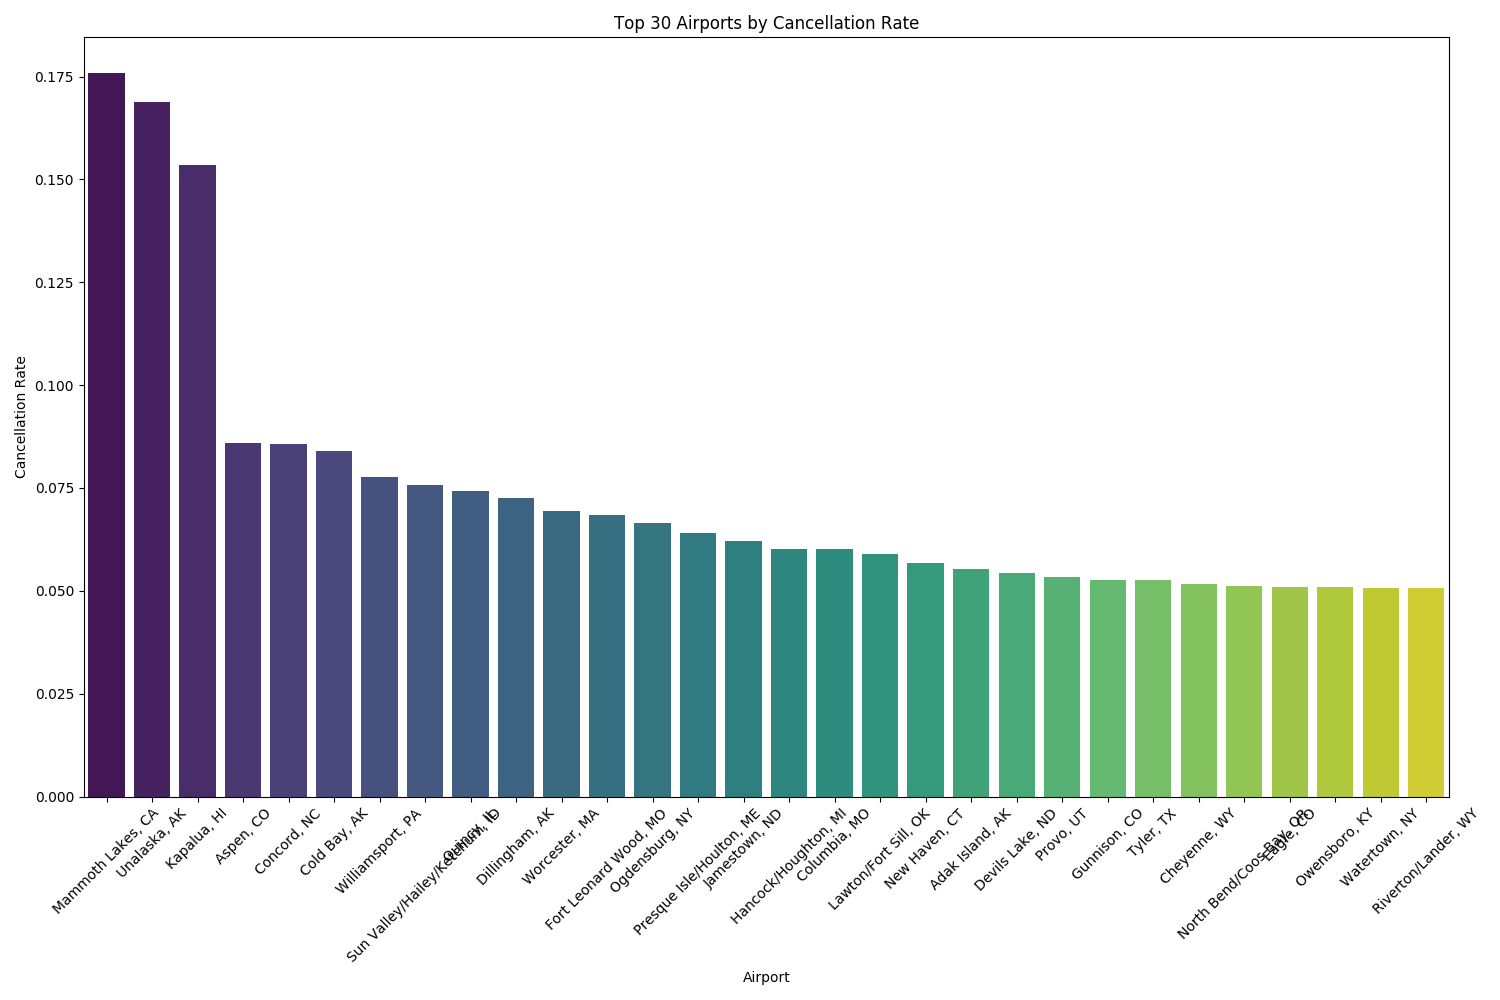

NameError: name 'top_cancellation_airports' is not defined

In [89]:
%matplot plt
# Convert to pandas for plotting
top_airports_pd = top_cancellation_airports.toPandas()

plt.figure(figsize=(15, 10))
sns.barplot(x=top_airports_pd["OriginCityName"], y=top_airports_pd["cancellation_rate"], palette="viridis")

plt.xticks(rotation=45)
plt.ylabel("Cancellation Rate")
plt.xlabel("Airport")
plt.title("Top 30 Airports by Cancellation Rate")
plt.tight_layout()
plt.show()

In [102]:
years = list(range(2018, 2022))
top_airports_by_year = {}

for year in years:
    yearly_data = combined_df.filter(F.col("Year") == year)
    
    airport_aggregated = yearly_data.groupBy("OriginCityName").agg(
        F.count("*").alias("total_flights"),
        F.sum(F.when(F.col("Cancelled") == True, 1).otherwise(0)).alias("cancelled_flights")
    )
    
    airport_aggregated = airport_aggregated.withColumn(
        "cancellation_rate", F.col("cancelled_flights") / F.col("total_flights")
    )
    
    sorted_airports = airport_aggregated.orderBy(F.desc("cancellation_rate"))
    
    top_airports_by_year[year] = sorted_airports.limit(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

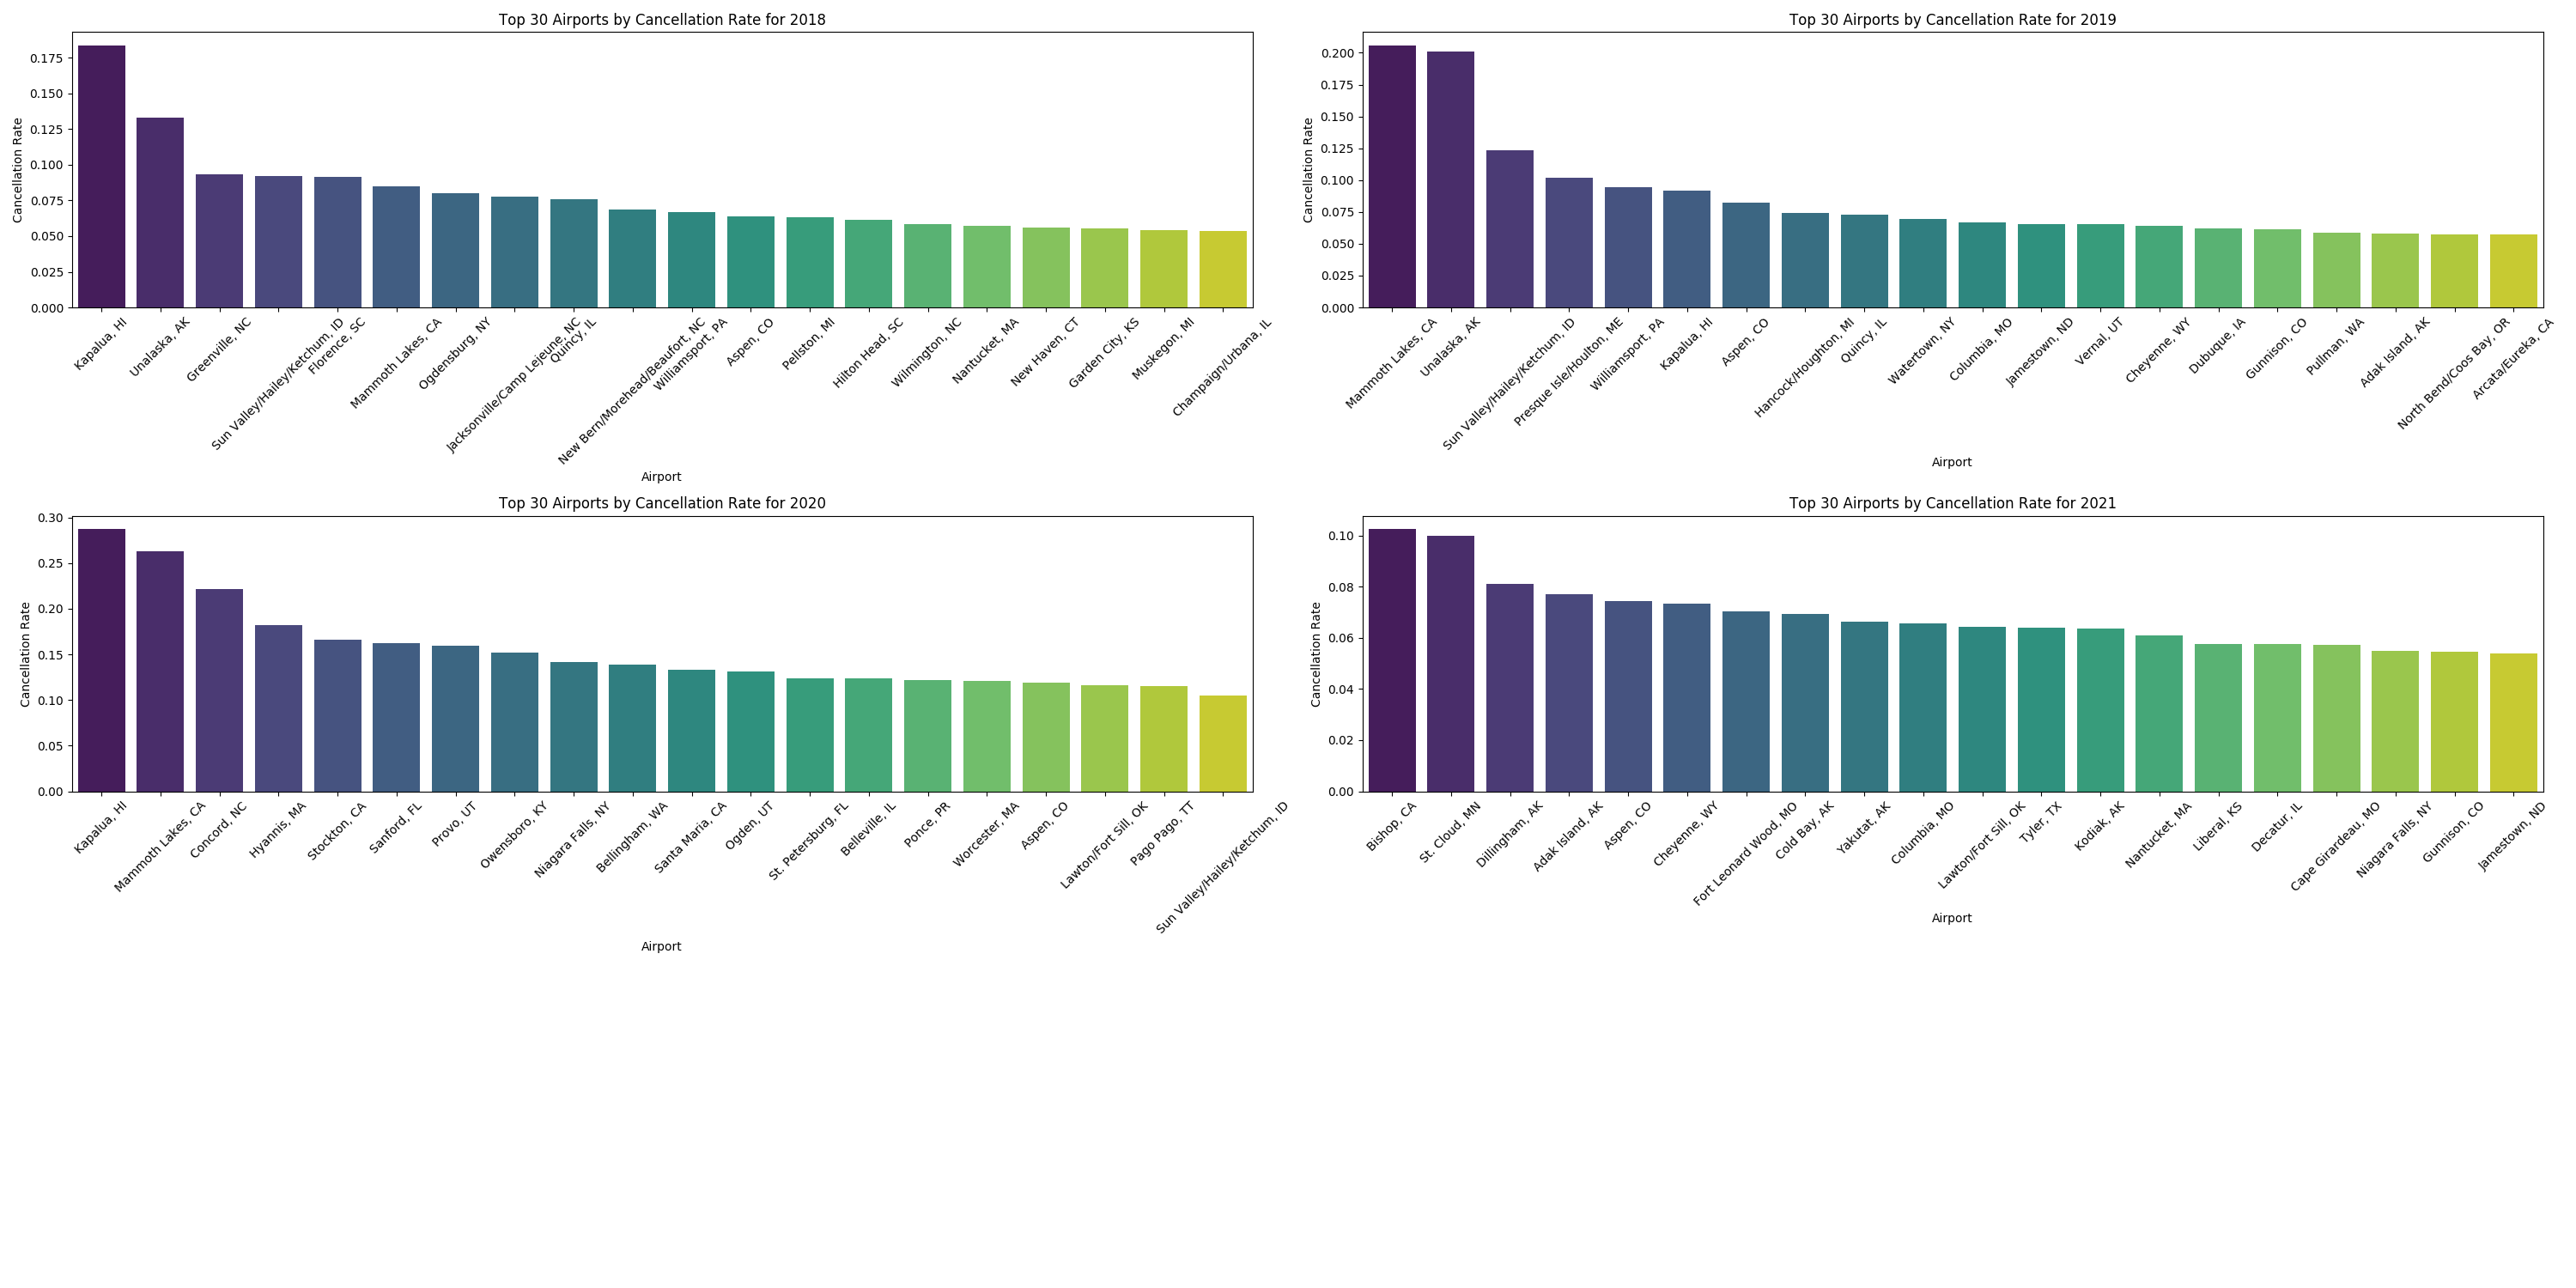

NameError: name 'plt' is not defined

In [101]:
%matplot plt
plt.figure(figsize=(30, 15))

for idx, year in enumerate(years, start=1):
    plt.subplot(3, 2, idx)  # 3 rows, 2 columns layout for 5 subplots
    
    top_airports_pd = top_airports_by_year[year].toPandas()
    
    sns.barplot(x=top_airports_pd["OriginCityName"], y=top_airports_pd["cancellation_rate"], palette="viridis")
    
    plt.xticks(rotation=45)
    plt.ylabel("Cancellation Rate")
    plt.xlabel("Airport")
    plt.title(f"Top 30 Airports by Cancellation Rate for {year}")

plt.tight_layout()
plt.show()

# Construct
In this stage we will
- Determine which models are most appropriate
- Construct the model
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data

## Key Assumption
- We will assume that the purpose of this project is to predict whether there will be a delay or cancellation **before the flight takes off**, as this is probably the most useful use case (an airplane that has taken off late would most probably be arriving late, but there is a ceiling to how late the aircraft can reach the destination as it only has so much fuel).

- This analysis would hopefully be more useful to customers **before** they embark on their trip, and airports and airlines can make arrangements **prior** to the Departure time of the airplane.

- Hence we will only Select columns which contain information that is known prior to a flight departing.

## Future Work (move to bottom)
- A possible extension to this project would be to quantify exactly how long a flight will be delayed for. 

- That project would require the full data set, with information like `TaxiOutTime` to more accurately determine the delay.

- However, what columns can be used to train the model would be highly dependent on the party who is actually conducting inference (using the model later), as some of the information like `TaxiOutTime` may not be available before a flight takes off.


In [20]:
column_subset = [
    "Year",
    "Month",
    "DayofMonth",
    "DayofWeek",
    "Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "CRSDepTime",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "CRSArrTime",
    "Distance",
]
column_subset_df = filtered_df.select(*column_subset)
column_subset_df.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----+----------+---------+-----------------+------+----+---------+----------+---------------+--------------+---------------+-------------+------------+-------------+----------+--------+
|Year|Month|DayofMonth|DayofWeek|          Airline|Origin|Dest|Cancelled|CRSDepTime|OriginAirportID|OriginCityName|OriginStateName|DestAirportID|DestCityName|DestStateName|CRSArrTime|Distance|
+----+-----+----------+---------+-----------------+------+----+---------+----------+---------------+--------------+---------------+-------------+------------+-------------+----------+--------+
|2018|    1|        23|        2|Endeavor Air Inc.|   ABY| ATL|    false|      1202|          10146|    Albany, GA|        Georgia|        10397| Atlanta, GA|      Georgia|      1304|   145.0|
|2018|    1|        24|        3|Endeavor Air Inc.|   ABY| ATL|    false|      1202|          10146|    Albany, GA|        Georgia|        10397| Atlanta, GA|      Georgia|      1304|   145.0|
|2018|    1|        25|        4|En

In [62]:
# Count the number of null values in each column
null_counts = [F.sum(F.when(F.isnull(c), 1).otherwise(0)).alias(c) for c in column_subset]

# Apply the aggregation on the DataFrame
result_df = column_subset_df.select(null_counts).collect()[0]

# Convert the result to a dictionary and then to a Pandas DataFrame for a tabular display
result_dict = {column_subset[i]: result_df[i] for i in range(len(column_subset))}
result_table = pd.DataFrame(list(result_dict.items()), columns=["Column", "Null Count"])

print(result_table)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             Column  Null Count
0              Year           0
1             Month           0
2        DayofMonth           0
3         DayofWeek           0
4           Airline           0
5            Origin           0
6              Dest           0
7         Cancelled           0
8        CRSDepTime           0
9   OriginAirportID           0
10   OriginCityName           0
11  OriginStateName           0
12    DestAirportID           0
13     DestCityName           0
14    DestStateName           0
15       CRSArrTime           0

## Baseline: Decision Tree Model

### PySpark's `StringIndexer`
- Helps convert categorical string columns in a DataFrame into numerical indices. 
- This conversion is necessary because most machine learning algorithms cannot work directly with string data.
- The StringIndexer processes the input column’s string values based on their frequency in the dataset. By default, the most frequent label receives the index 0, the second most frequent label receives index 1, and so on.

- If two categories have same frequency index value will be assigned based on the alphabetical order

- This is a version of **label encoding**

In [24]:
#convert column into type int
column_subset_df = column_subset_df.withColumn("Cancelled", F.col("Cancelled").cast("int"))

#remove 2020 due to anomolous data
column_subset_df = column_subset_df.filter(F.col("Year") != 2020)

string_columns = ["Airline", "Origin", "Dest", "OriginCityName", "OriginStateName", "DestCityName", "DestStateName"]


# Index string columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(column_subset_df) for column in string_columns]

# Update input_features list with new indexed column names and remove original string columns
input_features = [col+"_index" if col in string_columns else col for col in column_subset_df.columns if col != "Cancelled"]

# Feature Engineering using VectorAssembler
assembler = VectorAssembler(inputCols=input_features, outputCol="features")

# Splitting the Data
(train, test) = column_subset_df.randomSplit([0.8, 0.2], seed=42)

# Building the Model
dt = DecisionTreeClassifier(labelCol="Cancelled", featuresCol="features", maxBins=400)

# Setting up the pipeline
pipeline = Pipeline(stages=indexers + [assembler, dt])

# Train the model using pipeline
model = pipeline.fit(train)

# Make Predictions
predictions = model.transform(test)



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# Evaluation
evaluator_binary = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Cancelled")
auc = evaluator_binary.evaluate(predictions)

print(f"AUC: {auc}")

# Multiclass Evaluation
evaluator_multi = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")
# Calculate and print the evaluation metrics
accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Weighted Precision: {precision:.4f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

AUC: 0.5
Accuracy: 0.9802
F1 Score: 0.9705
Weighted Precision: 0.9609

This classification model has failed. It is as good as flipping a coin, despite strong accuracy and precision.

## Narrowing the Project Scope
What was learnt from training the model:
1. The data is really big and takes a lot of time to test. Going forward, let us narrow the scope and proceed with trying to predict the cancellations for a single airport as a proof of concept. If time and costs allow, we can then extend the model to the full data set.

2. There are not enough meaningful features for the model to make good predictions. According to [Wikipedia](https://en.wikipedia.org/wiki/Flight_cancellation_and_delay), some of the causes of flight delays or cancellation include:

- Congestion in air traffic
- Earthquakes and tsunamis (e.g., in the event of 2004 Indian Ocean earthquake and tsunami, 2010 Chile earthquake, and the 2011 Tōhoku earthquake and tsunami)
- Fueling
- Inclement weather, such as thunderstorm, hurricane, or blizzard
- Late arrival of the aircraft to be used for the flight from a previous flight
- Maintenance problems with the aircraft
- Security issues

However, most of these features are not captured in the dataset. Hence it is difficult for our model to predict accurately whether there will be cancellations. 

We will try to overcome this by joining our flight status dataset with [weather data](https://www.kaggle.com/datasets/sobhanmoosavi/us-weather-events?select=WeatherEvents_Jan2016-Dec2022.csv). The data itself comes from [LSTW](https://smoosavi.org/datasets/lstw), which is is a large-scale, country-wide dataset for transportation and traffic research, which contains traffic and weather event data for the United States.  



In [128]:

top_origin = (
    filtered_df.groupBy("Origin")
    .count()
    .orderBy(F.desc("count"))
    .first()
)

print(f"The 'Origin' with the highest number of rows is: {top_origin['Origin']} with {top_origin['count']} rows.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The 'Origin' with the highest number of rows is: ORD with 1371787 rows.

In [111]:
total_rows = filtered_df.count()
print(f"Total number of rows in filtered_data: {total_rows}")
print(f"proportion of ORD rows to total rows:{top_origin['count']/total_rows}.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total number of rows in filtered_data: 29125433
proportion of ORD rows to total rows:0.04709928260980704.

- We shall choose to analyse the cancellations at ORD only because it is the 'Origin' with the highest number of rows, and it significantly decreases the sample data.

### Check if ORD is a good sample of representative sample point

In [123]:
#convert cancellation to int type
airport_aggregated_cancellations = combined_df.groupBy("Origin").agg(
    F.count("*").alias("total_flights"),
    F.sum(F.when(F.col("Cancelled") == True, 1).otherwise(0)).alias("cancelled_flights")
)

#compute cancellation rate
airport_aggregated_cancellations = airport_aggregated_cancellations.withColumn(
    "cancellation_rate", F.col("cancelled_flights") / F.col("total_flights")
)

airport_rates_df = airport_aggregated_cancellations.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

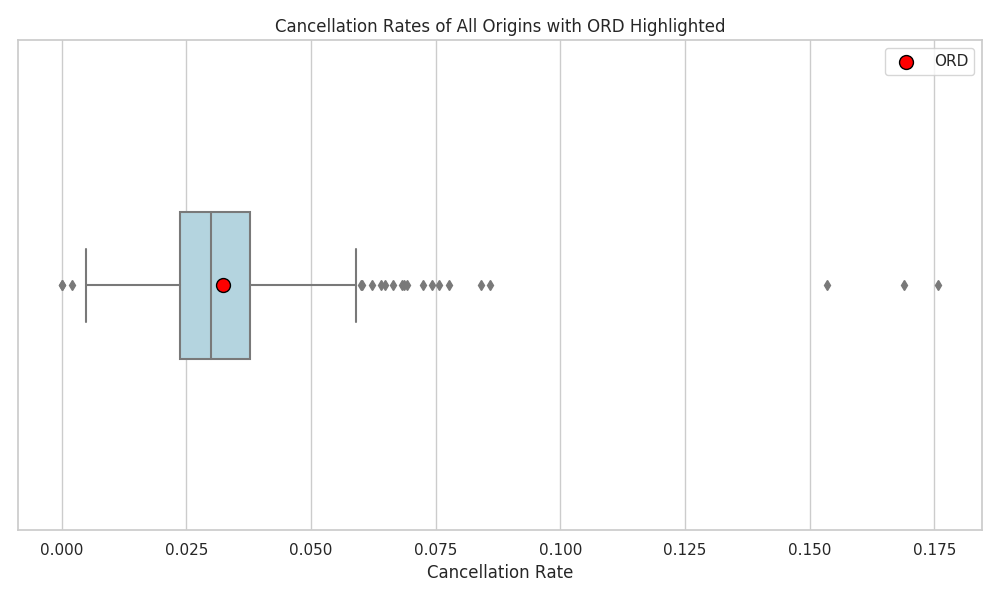

NameError: name 'sns' is not defined

In [125]:
%matplot plt
# Set style for seaborn
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=airport_rates_df['cancellation_rate'], color='lightblue', fliersize=5, linewidth=1.5, width=0.3)

# Highlight ORD's cancellation rate
ord_rate = airport_rates_df[airport_rates_df["Origin"] == "ORD"]["cancellation_rate"].iloc[0]
plt.scatter(ord_rate, 0, color='red', s=100, label='ORD', zorder=5, edgecolor="black")

plt.xlabel('Cancellation Rate')
plt.title('Cancellation Rates of All Origins with ORD Highlighted')
plt.legend()

plt.tight_layout()
plt.show()

- ORD is not an outlier, so analysing ORD should give a rough indication of how other airports do in terms of cancellations

In [28]:
ord_df = filtered_df.filter(filtered_df['Origin'] == 'ORD')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Joining FlightStatus and Weather Data
- The weather data gives the weather conditions for airports around the US from 2016 to 2022.

- We will first filter and keep weather data for ORD and then joing the data on FlightDate.

### Compatibility
- We note that the dates and times in the flight status data set are local time but the weather data has dates and times in UTC so we need to adjust this

In [29]:
weather_df = spark.read.csv("s3://airplane-data-240823/WeatherEvents_Jan2016-Dec2022.csv", header=True, inferSchema=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
ord_weather_df = weather_df.filter(weather_df.AirportCode == "KORD")
ord_weather_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

4439

In [31]:
# change UTC time to Chicago local time to match flight status data
ord_weather_df = ord_weather_df.withColumn("StartTime(UTC)", F.from_utc_timestamp(F.col("StartTime(UTC)"), "CST"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
# Extract date from the StartTime(Chicago) column in ord_weather_df
ord_weather_df = ord_weather_df.withColumn("Date", F.to_date(F.col("StartTime(UTC)")))

# Format the FlightDate column in ord_df to match the extracted date format
#ord_df = ord_df.withColumn("FlightDateFormatted", F.to_date(F.col("FlightDate"), "yyyyMMdd"))

# ord_weather_df.select("Date").show(10)
# Join the two dataframes
joined_df = ord_df.join(ord_weather_df, ord_df.FlightDate == ord_weather_df.Date, "inner")

# Select the relevant columns including 'Type' from ord_weather_df
final_df = joined_df.select(ord_df["*"], ord_weather_df["Type"])
final_df = final_df.withColumnRenamed("Type", "OriginWeather")

# final_df.select("Type", "FlightDate").show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
final_df = final_df.withColumn("Dest", F.concat(F.lit("K"), final_df["Dest"]))


weather_df = weather_df.withColumn("Date", F.to_date(F.col("StartTime(UTC)")))

# # Join with weather_df to get 'DestinationWeather'
# final_df = final_df.join(
#     weather_df.withColumnRenamed("Type", "DestinationWeather"), 
#     (final_df.FlightDate == weather_df.Date) & (final_df.Dest == weather_df.AirportCode),
#     "inner")
# final_df.select("Date","DestinationWeather").show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
column_subset = [
    "Year",
    "Month",
    "DayofMonth",
    "DayofWeek",
    "Airline",
    "Dest",
    "Cancelled",
    "CRSDepTime",
    "CRSArrTime",
    "OriginWeather"
]
final_df = final_df.select(*column_subset)
final_df.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----+----------+---------+--------------------+----+---------+----------+----------+-------------+
|Year|Month|DayofMonth|DayofWeek|             Airline|Dest|Cancelled|CRSDepTime|CRSArrTime|OriginWeather|
+----+-----+----------+---------+--------------------+----+---------+----------+----------+-------------+
|2018|    1|        21|        7|   Endeavor Air Inc.|KMSP|    false|      1103|      1240|          Fog|
|2018|    1|        21|        7|   Endeavor Air Inc.|KMSP|    false|      1103|      1240|          Fog|
|2018|    1|        21|        7|   Endeavor Air Inc.|KMSP|    false|      1103|      1240|          Fog|
|2018|    1|        21|        7|ExpressJet Airlin...|KTVC|    false|      2057|      2310|          Fog|
|2018|    1|        21|        7|ExpressJet Airlin...|KTVC|    false|      2057|      2310|          Fog|
|2018|    1|        21|        7|ExpressJet Airlin...|KTVC|    false|      2057|      2310|          Fog|
|2018|    1|        21|        7|ExpressJet Ai

In [175]:
# Train a model
# 1. Convert the boolean column "Cancelled" to a numeric format
final_df = final_df.withColumn("Cancelled", final_df["Cancelled"].cast("integer"))

# 2. Numerically encode the categorical columns
categorical_columns = ["Year", "Month", "DayofMonth", "DayofWeek", "Airline", "Dest", "OriginWeather"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(final_df) for column in categorical_columns]

# 3. Assemble the features
feature_columns = [column+"_index" for column in categorical_columns] + ["CRSDepTime", "CRSArrTime"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# 4. Split the data
(trainingData, testData) = final_df.randomSplit([0.7, 0.3], seed=42)

# 5. Train a decision tree classifier
dt = DecisionTreeClassifier(labelCol="Cancelled", featuresCol="features", maxBins=220)

# 6. Set up the pipeline
pipeline = Pipeline(stages=indexers + [assembler, dt])

# Train model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

# Optionally, evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Error = {(1.0 - accuracy):.2f}")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Error = 0.07

In [176]:
# Calculate and print the evaluation metrics
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Weighted Precision: {precision:.4f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy: 0.9254
F1 Score: 0.9057
Weighted Precision: 0.9026

In [177]:
# Instantiate the evaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calculate AUC
auc = binary_evaluator.evaluate(predictions)

print(f"AUC: {auc:.4f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

AUC: 0.3473

# Problem: Imbalanced Dataset

- Eventhough the accuracy is high, the AUC is even worse than a random classifier!

- One possibility would be to take 1-AUC by flipping the predictions. So at least the model is finding *some sort of relationship*

## Duplicating the Minority Class
- To attempt to fix the class imbalance, we will make a copy of each row where Cancelled=True

In [39]:
#1. Get rid of flights from anomolous year 2020
final_df = final_df.filter(F.col("Year") != 2020)

# 2. Separate the data
cancelled_flights = final_df.filter(F.col("Cancelled") == True)
not_cancelled_flights = final_df.filter(F.col("Cancelled") == False)

# 3. Duplicate the rows of cancelled flights
oversampled_cancelled_flights = cancelled_flights.union(cancelled_flights)
oversampled_cancelled_flights = oversampled_cancelled_flights.union(cancelled_flights)

# 4. Combine the two datasets
balanced_final_df = not_cancelled_flights.union(oversampled_cancelled_flights)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
# Train a model
# 1. Convert the boolean column "Cancelled" to a numeric format
balanced_final_df = balanced_final_df.withColumn("Cancelled", balanced_final_df["Cancelled"].cast("integer"))

# 2. Numerically encode the categorical columns
categorical_columns = ["Year", "Month", "DayofMonth", "DayofWeek", "Airline", "Dest", "OriginWeather"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(balanced_final_df) for column in categorical_columns]

# 3. Assemble the features
feature_columns = [column+"_index" for column in categorical_columns] + ["CRSDepTime", "CRSArrTime"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# 4. Split the data
(trainingData, testData) = balanced_final_df.randomSplit([0.7, 0.3], seed=42)

# 5. Train a decision tree classifier
dt = DecisionTreeClassifier(labelCol="Cancelled", featuresCol="features", maxBins=220)

# 6. Set up the pipeline
pipeline = Pipeline(stages=indexers + [assembler, dt])

# Train model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
# Calculate and print the evaluation metrics
evaluator = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Weighted Precision: {precision:.4f}")

# Instantiate the evaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calculate AUC
auc = binary_evaluator.evaluate(predictions)

print(f"AUC: {auc:.4f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy: 0.8467
F1 Score: 0.8252
Weighted Precision: 0.8284
AUC: 0.5771

It seems the AUC score has improved, and is at least more than 0.5!
### Let's Try the GBT Predictor

In [44]:
# Train a model
# 1. Convert the boolean column "Cancelled" to a numeric format
balanced_final_df = balanced_final_df.withColumn("Cancelled", balanced_final_df["Cancelled"].cast("integer"))

# 2. Numerically encode the categorical columns
categorical_columns = ["Year", "Month", "DayofMonth", "DayofWeek", "Airline", "Dest", "OriginWeather"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(balanced_final_df) for column in categorical_columns]

# 3. Assemble the features
feature_columns = [column+"_index" for column in categorical_columns] + ["CRSDepTime", "CRSArrTime"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# 4. Split the data
(trainingData, testData) = balanced_final_df.randomSplit([0.7, 0.3], seed=42)

# 5. Train a decision tree classifier
gbt = GBTClassifier(labelCol="Cancelled", featuresCol="features", maxBins=220, maxIter=10)

# 6. Set up the pipeline
pipeline = Pipeline(stages=indexers + [assembler, gbt])

# Train model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
# Calculate and print the evaluation metrics
evaluator = MulticlassClassificationEvaluator(
    labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Weighted Precision: {precision:.4f}")

# Instantiate the evaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calculate AUC
auc = binary_evaluator.evaluate(predictions)

print(f"AUC: {auc:.4f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy: 0.8739
F1 Score: 0.8606
Weighted Precision: 0.8647
AUC: 0.8749